#  Analyse  for holo at AuxTel for Scan data

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date :November 2nd 2021


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [4]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

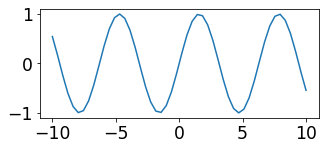

In [5]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [6]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [7]:
from datetime import datetime,date

In [8]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [9]:
string_date

'2021-11-18'

In [10]:
from iminuit import Minuit
import iminuit

In [11]:
iminuit.__version__

'2.7.0'

In [12]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [13]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [14]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [15]:
from time import sleep

In [16]:
from astropy.time import Time
import astropy.units as u

# Function

In [17]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^holo4_003_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target(filename):
    m = re.findall('^holo4_003_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

# Config

In [18]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [19]:
version="v4.0"

# Path

In [20]:
HOSTCC=False

In [21]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/softs/github/lsst/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

In [22]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [23]:
! ls -l /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000234_quickLookExp/basespec

total 19384
-rw-r--r--  1 dagoret  staff      607 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_lines.csv
-rw-r--r--  1 dagoret  staff  4970880 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_spectrogram.fits
-rw-r--r--  1 dagoret  staff  4754880 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_spectrum.fits
-rw-r--r--  1 dagoret  staff   191794 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_table.csv


In [24]:

# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

# Logbook for file selection

In [25]:
# Logbook for scan data
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_'+ version+'.csv'

In [26]:
df=pd.read_csv(filename_logbook,index_col=0)

In [27]:
pd.set_option('display.max_rows', None)

In [28]:
df

index                     date  \
0        0  2021-07-08T02:50:31.569   
1        1  2021-07-08T02:51:12.101   
2        2  2021-07-08T02:51:21.256   
3        3  2021-07-08T02:51:30.934   
4        4  2021-07-08T02:51:40.885   
5        5  2021-07-08T02:51:50.381   
6        6  2021-07-08T02:51:59.759   
7        7  2021-07-08T02:52:10.113   
8        8  2021-07-08T02:52:19.262   
9        9  2021-07-08T02:52:29.022   
10      10  2021-07-08T03:09:18.381   
11      11  2021-07-08T03:09:51.483   
12      12  2021-07-08T03:10:22.899   
13      13  2021-07-08T03:10:54.635   
14      14  2021-07-08T03:14:25.113   
15      15  2021-07-08T03:18:49.728   
16      16  2021-07-08T03:22:35.058   
17      17  2021-07-08T03:27:28.637   
18      18  2021-07-08T03:31:49.398   
19      19  2021-07-08T03:33:02.383   
20      20  2021-07-08T03:33:40.416   
21      21  2021-07-08T03:34:18.506   
22      22  2021-07-08T03:34:56.504   
23      23  2021-07-08T03:35:34.622   
24      24  2021-07-08T03:36:12.773   
25      25  2021-07-08T03:36:51.324   
26      26  2021-07-08T03:37:29.434   
27      27  2021-07-08T03:38:07.561   
28      28  2021-07-08T03:38:45.707   
29      29  2021-07-08T03:39:23.969   
30      30  2021-07-08T03:40:02.136   
31      31  2021-07-08T03:40:40.864   
32      32  2021-07-08T03:41:19.059   
33      33  2021-07-08T03:41:57.407   
34      34  2021-07-08T03:42:35.608   
35      35  2021-07-08T03:43:13.804   
36      36  2021-07-08T03:43:52.018   
37      37  2021-07-08T03:44:30.763   
38      38  2021-07-08T03:45:08.962   
39      39  2021-07-08T03:45:47.206   
40      40  2021-07-08T03:46:25.307   
41      41  2021-07-08T03:47:03.492   
42      42  2021-07-08T03:47:41.807   
43      43  2021-07-08T03:48:20.795   
44      44  2021-07-08T03:48:58.912   
45      45  2021-07-08T03:49:37.128   
46      46  2021-07-08T03:50:15.298   
47      47  2021-07-08T03:50:53.476   
48      48  2021-07-08T03:51:31.752   
49      49  2021-07-08T03:52:10.906   
50      50  2021-07-08T03:52:49.130   
51      51  2021-07-08T03:53:27.487   
52      52  2021-07-08T03:54:05.770   
53      53  2021-07-08T03:54:44.149   
54      54  2021-07-08T03:55:22.356   
55      55  2021-07-08T03:57:27.244   
56      56  2021-07-08T04:01:50.450   
57      57  2021-07-08T04:04:12.555   
58      58  2021-07-08T04:05:06.367   
59      59  2021-07-08T04:05:38.880   
60      60  2021-07-08T04:06:11.311   
61      61  2021-07-08T04:06:43.769   
62      62  2021-07-08T04:07:16.223   
63      63  2021-07-08T04:07:48.665   
64      64  2021-07-08T04:08:21.107   
65      65  2021-07-08T04:08:54.078   
66      66  2021-07-08T04:09:26.572   
67      67  2021-07-08T04:09:59.052   
68      68  2021-07-08T04:10:31.515   
69      69  2021-07-08T04:11:03.986   
70      70  2021-07-08T04:11:36.404   
71      71  2021-07-08T04:12:08.868   
72      72  2021-07-08T04:22:19.093   
73      73  2021-07-08T04:22:52.079   
74      74  2021-07-08T04:23:23.868   
75      75  2021-07-08T04:27:28.703   
76      76  2021-07-08T04:49:32.013   
77      77  2021-07-08T04:50:04.270   
78      78  2021-07-08T04:50:36.514   
79      79  2021-07-08T04:51:08.758   
80      80  2021-07-08T04:51:41.005   
81      81  2021-07-08T04:52:13.265   
82      82  2021-07-08T04:52:45.515   
83      83  2021-07-08T04:53:18.264   
84      84  2021-07-08T04:53:50.521   
85      85  2021-07-08T04:54:22.770   
86      86  2021-07-08T04:54:55.016   
87      87  2021-07-08T04:55:27.314   
88      88  2021-07-08T04:55:59.559   
89      89  2021-07-08T04:56:31.807   
90      90  2021-07-08T04:57:04.543   
91      91  2021-07-08T04:57:36.808   
92      92  2021-07-08T04:58:09.080   
93      93  2021-07-08T04:58:41.316   
94      94  2021-07-08T04:59:13.646   
95      95  2021-07-08T04:59:45.917   
96      96  2021-07-08T05:00:18.159   
97      97  2021-07-08T05:00:50.866   
98      98  2021-07-08T05:01:23.102   
99      99  2021-07-08T05:01:55.386   
100    100  2021-07-08T05:02:27.623   
101    101  2021-07-08T05:0

# Selection of input file

In [29]:
# Do not consider flag
df_good=df[df["quality"]==1]

In [30]:
# Select narrow scan
#df_good=df[df["num"]>=317]

In [31]:
df_good=df[df["num"]>=247]

In [32]:
# With filter
df_good=df[df["num"] != 306]
df_good=df[df["num"] != 307]
df_good=df[df["num"] != 308]

In [33]:
#df_good

In [34]:
all_good_spectra=[]
for spectra_file in df_good["file"]:
    print(spectra_file)
    all_good_spectra.append(spectra_file)

holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000250_quickLookExp.fi

# Selection of Spectractor output files

In [35]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [36]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)

for subdir in list_of_files:
    
    
    tag=file_tag_forsorting(subdir)
   
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
    if tag <= "000247" : # remove files with filters
        continue
        
    #if tag == "000250" or tag == "000251"  or tag == "000252": # remove file bad angle
    #    continue
        
    if tag == "000306" or tag == "000307" or tag == "000308" : # remove files with filters
        continue
        
    if tag =="000264" :   # creazy reconstruction, truncation on right
        continue
        
    if tag=="000327" or tag=="000333" or tag == "000350" or tag == "000351":
        continue
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))

        NBEXPNODIR+=1


    else:



        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=file_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        targetname=file_target(subdir)
        print("targetname= {}".format(targetname))

        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)






LISTNUM=sorted(LISTNUM)
LISTNUMNODIR=sorted(LISTNUMNODIR)
LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


---------------------------------------------
holo4_003_empty_HD160617_20210707_000248_quickLookExp  	   000248
holo4_003_empty_HD160617_20210707_000248_quickLookExp is a directory
tagname= 000248
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000249_quickLookExp  	   000249
holo4_003_empty_HD160617_20210707_000249_quickLookExp is a directory
tagname= 000249
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000250_quickLookExp  	   000250
holo4_003_empty_HD160617_20210707_000250_quickLookExp is a directory
tagname= 000250
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000251_quickLookExp  	   000251
holo4_003_empty_HD160617_20210707_000251_quickLookExp is a directory
tagname= 

In [37]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000251_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000252_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000265_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000266_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectra

In [38]:
! ls /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000336_quickLookExp/basespec

holo4_003_empty_HD160617_20210707_000336_quickLookExp_lines.csv
holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrogram.fits
holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits
holo4_003_empty_HD160617_20210707_000336_quickLookExp_table.csv


In [39]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [40]:
all_files_spectra[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits']

In [41]:
all_files_spectrogram[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrogram.fits']

In [42]:
all_files_lines[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_lines.csv']

In [43]:
all_files_table[:3] 

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_table.csv']

# Selection of good spectra

In [44]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [45]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [46]:
filename.split(".")[0]

'holo4_003_empty_HD160617_20210707_000349_quickLookExp_table'

0 ) holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits


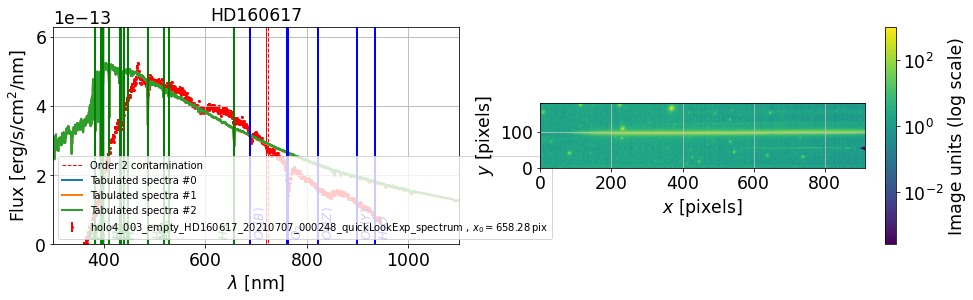

1 ) holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits


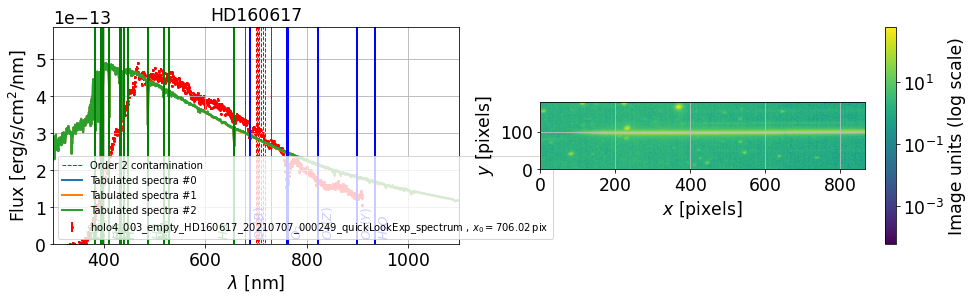

2 ) holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits


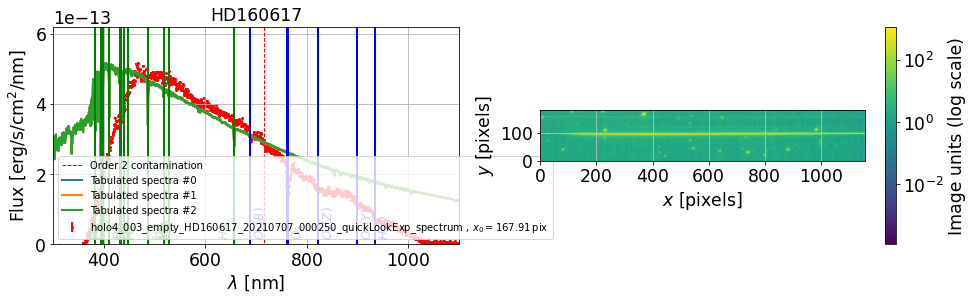

3 ) holo4_003_empty_HD160617_20210707_000251_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000251_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000251_quickLookExp_spectrum.fits


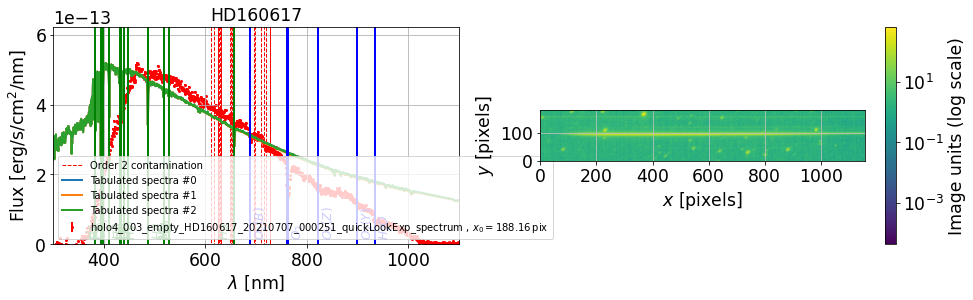

4 ) holo4_003_empty_HD160617_20210707_000252_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000252_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000252_quickLookExp_spectrum.fits


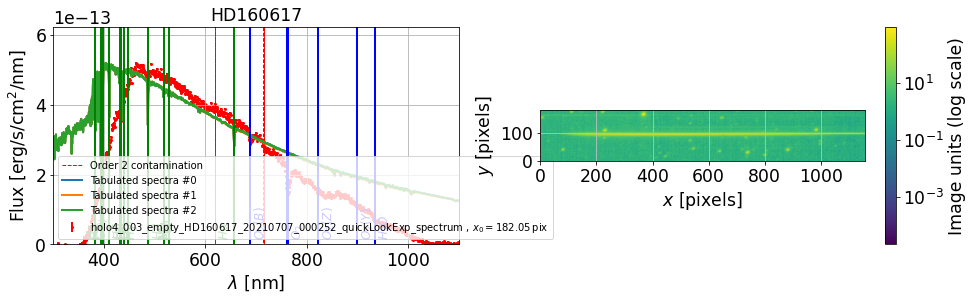

5 ) holo4_003_empty_HD160617_20210707_000265_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000265_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000265_quickLookExp_spectrum.fits


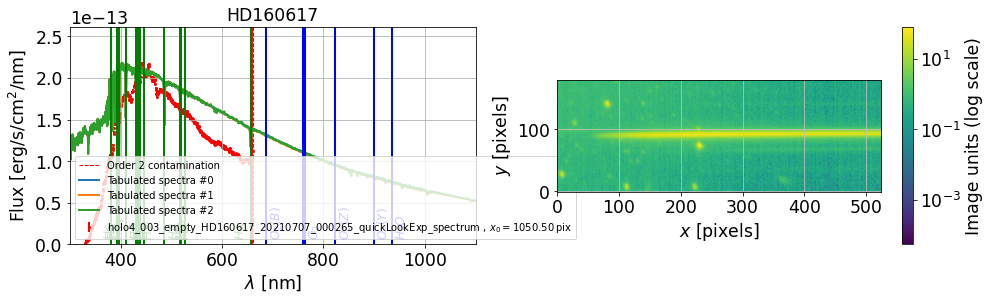

6 ) holo4_003_empty_HD160617_20210707_000266_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000266_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000266_quickLookExp_spectrum.fits


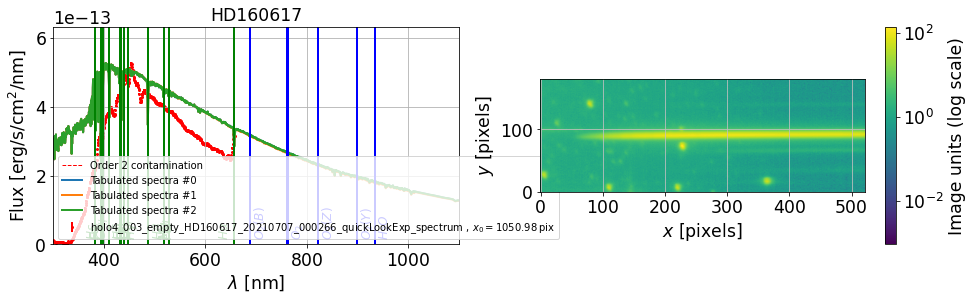

7 ) holo4_003_empty_HD160617_20210707_000267_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000267_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000267_quickLookExp_spectrum.fits


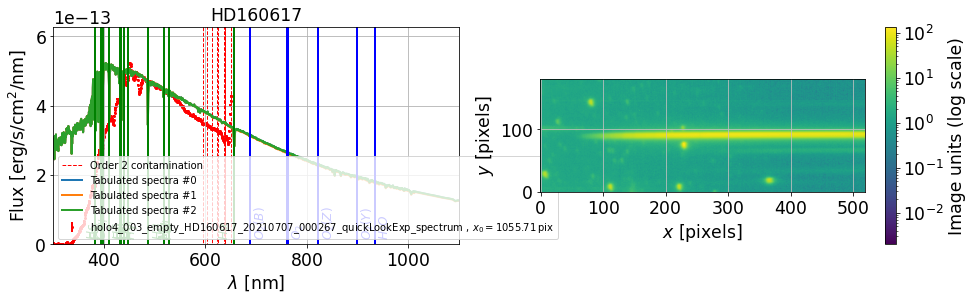

8 ) holo4_003_empty_HD160617_20210707_000268_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000268_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000268_quickLookExp_spectrum.fits


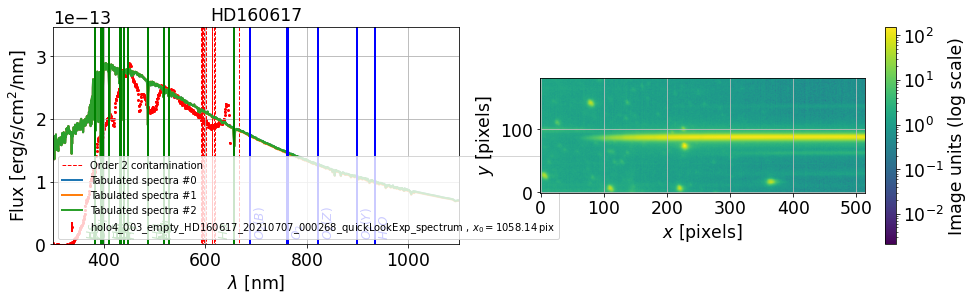

9 ) holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrum.fits


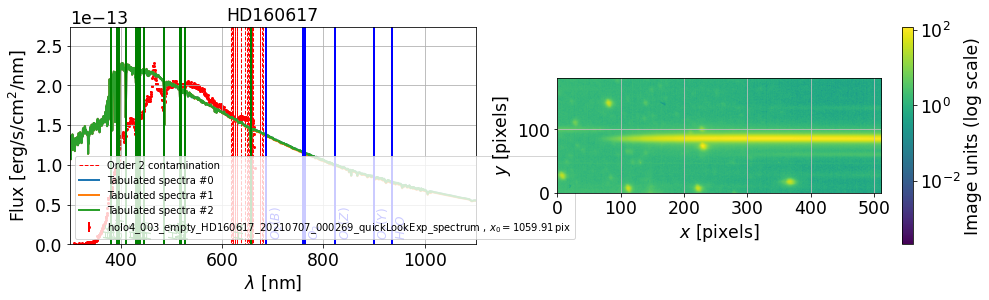

10 ) holo4_003_empty_HD160617_20210707_000270_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000270_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000270_quickLookExp_spectrum.fits


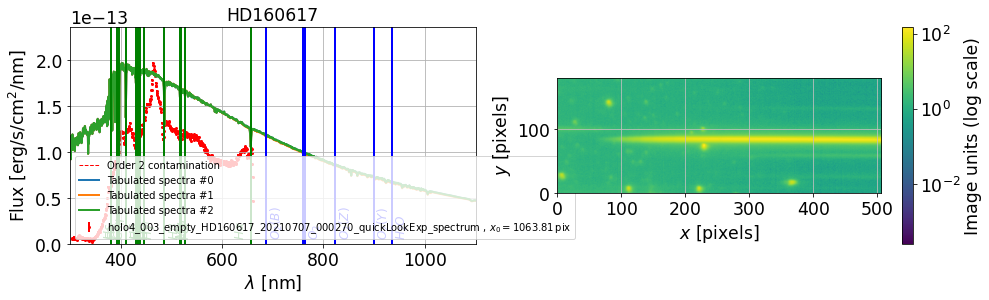

11 ) holo4_003_empty_HD160617_20210707_000272_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000272_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000272_quickLookExp_spectrum.fits


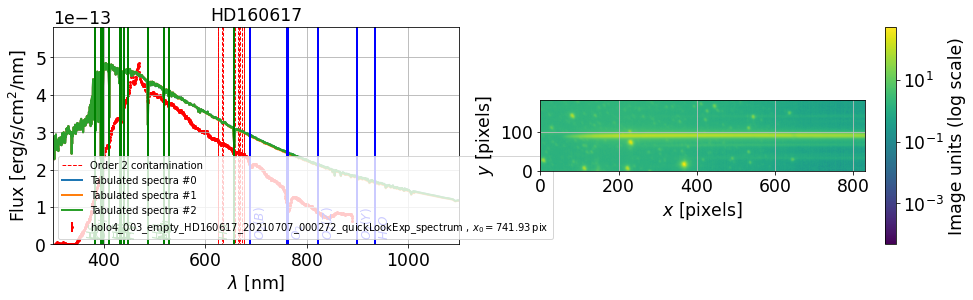

12 ) holo4_003_empty_HD160617_20210707_000273_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000273_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000273_quickLookExp_spectrum.fits


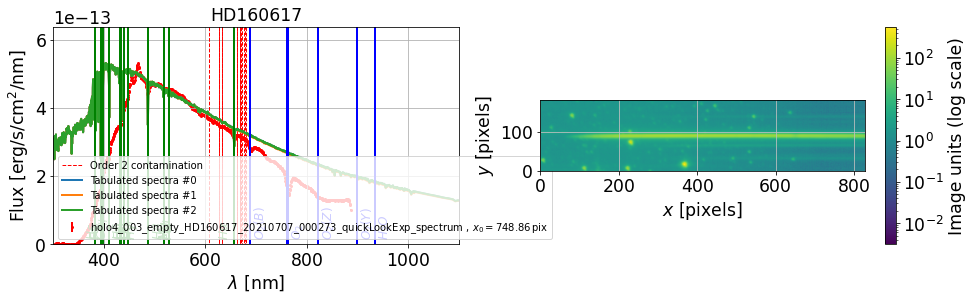

13 ) holo4_003_empty_HD160617_20210707_000274_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000274_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000274_quickLookExp_spectrum.fits


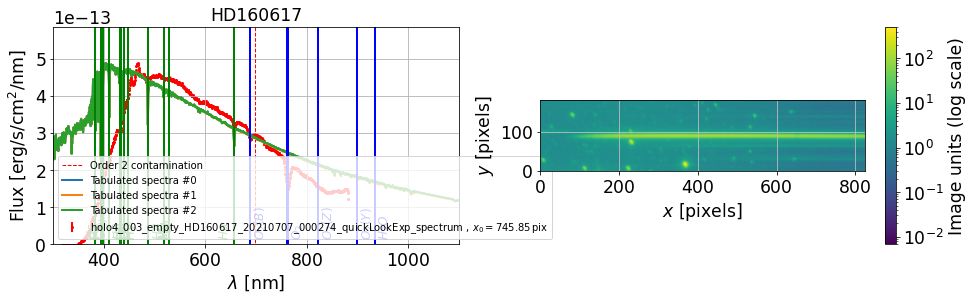

14 ) holo4_003_empty_HD160617_20210707_000276_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000276_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000276_quickLookExp_spectrum.fits


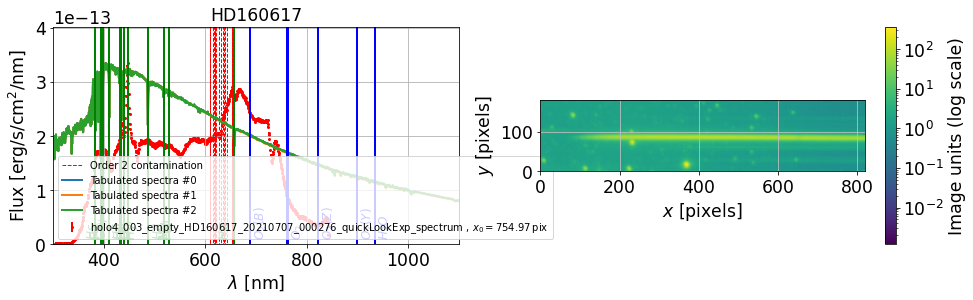

15 ) holo4_003_empty_HD160617_20210707_000278_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000278_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000278_quickLookExp_spectrum.fits


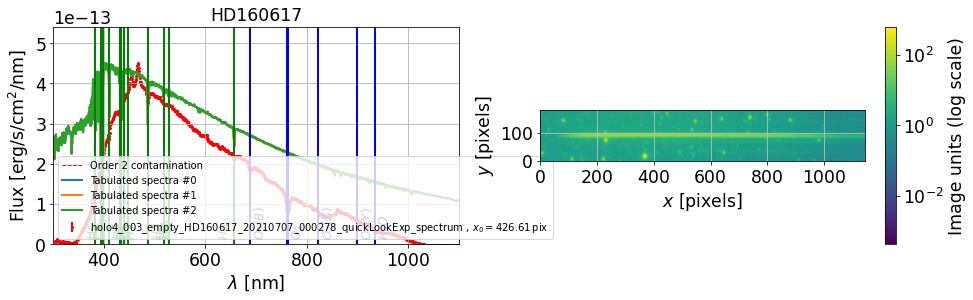

16 ) holo4_003_empty_HD160617_20210707_000279_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000279_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000279_quickLookExp_spectrum.fits


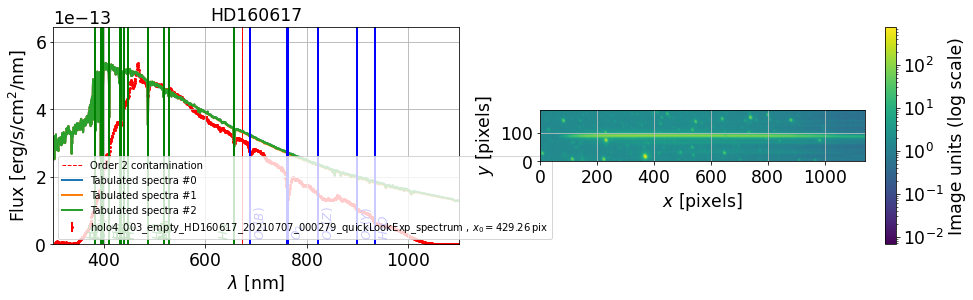

17 ) holo4_003_empty_HD160617_20210707_000280_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000280_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000280_quickLookExp_spectrum.fits


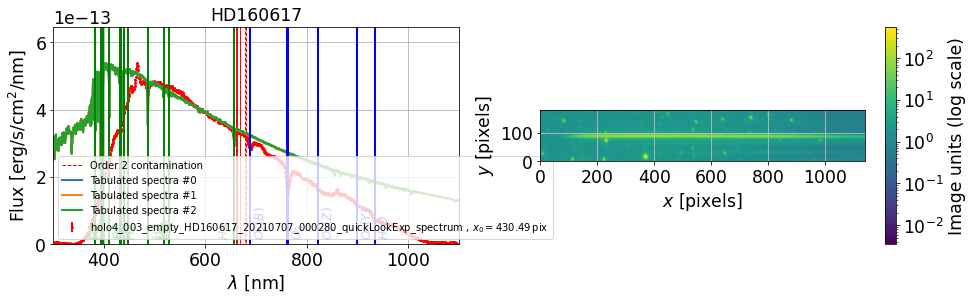

18 ) holo4_003_empty_HD160617_20210707_000282_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000282_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000282_quickLookExp_spectrum.fits


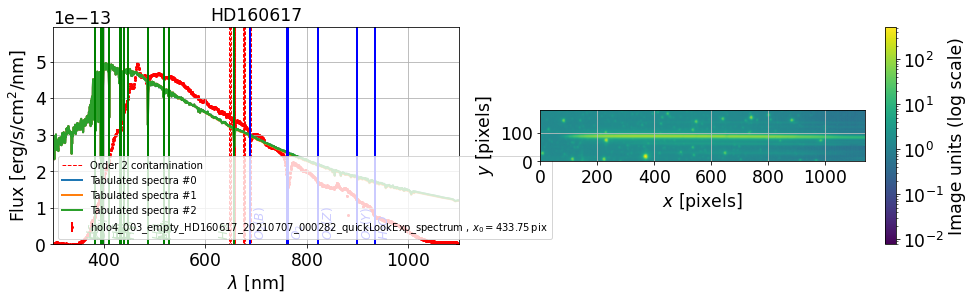

19 ) holo4_003_empty_HD160617_20210707_000284_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000284_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000284_quickLookExp_spectrum.fits


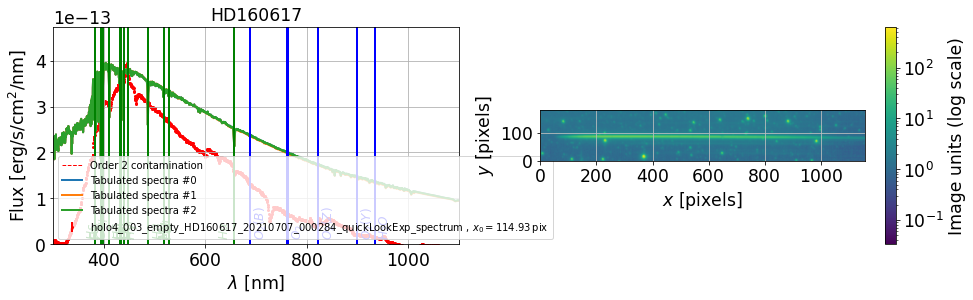

20 ) holo4_003_empty_HD160617_20210707_000285_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000285_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000285_quickLookExp_spectrum.fits


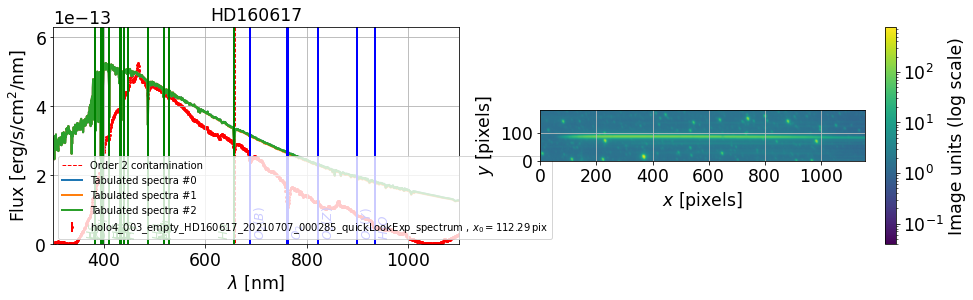

21 ) holo4_003_empty_HD160617_20210707_000286_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000286_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000286_quickLookExp_spectrum.fits


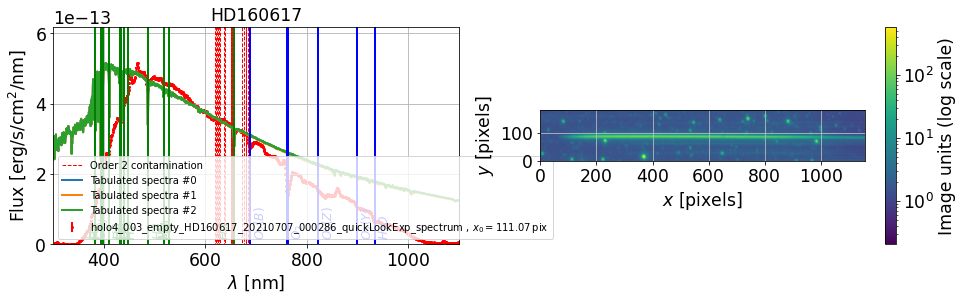

22 ) holo4_003_empty_HD160617_20210707_000287_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000287_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000287_quickLookExp_spectrum.fits


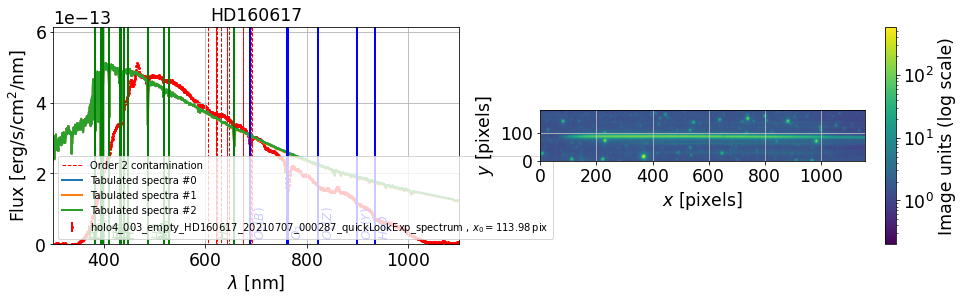

23 ) holo4_003_empty_HD160617_20210707_000288_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000288_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000288_quickLookExp_spectrum.fits


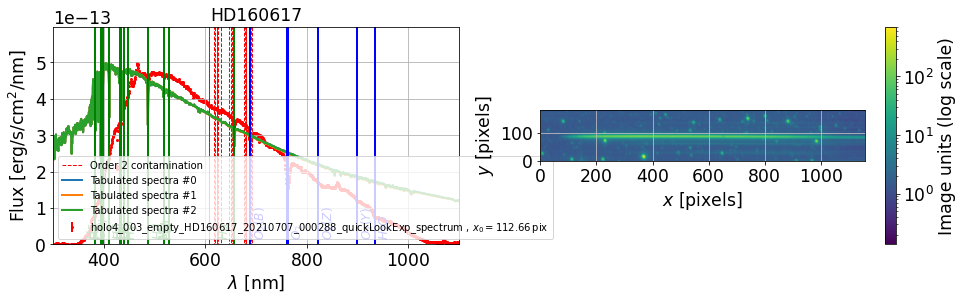

24 ) holo4_003_empty_HD160617_20210707_000289_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000289_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000289_quickLookExp_spectrum.fits


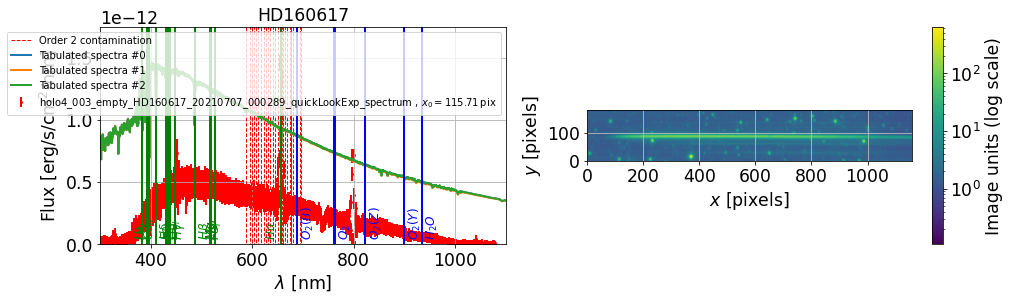

25 ) holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits


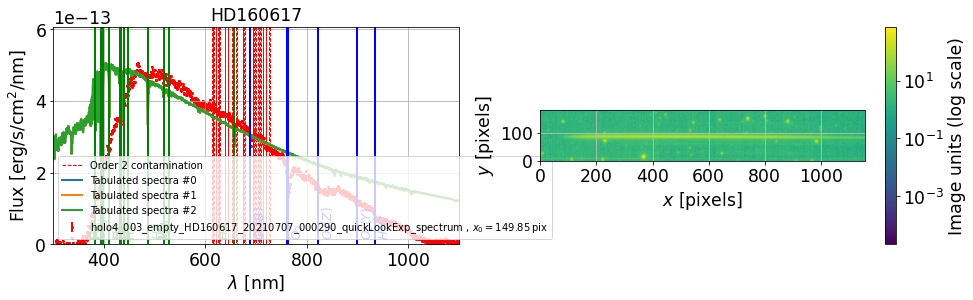

26 ) holo4_003_empty_HD160617_20210707_000291_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000291_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000291_quickLookExp_spectrum.fits


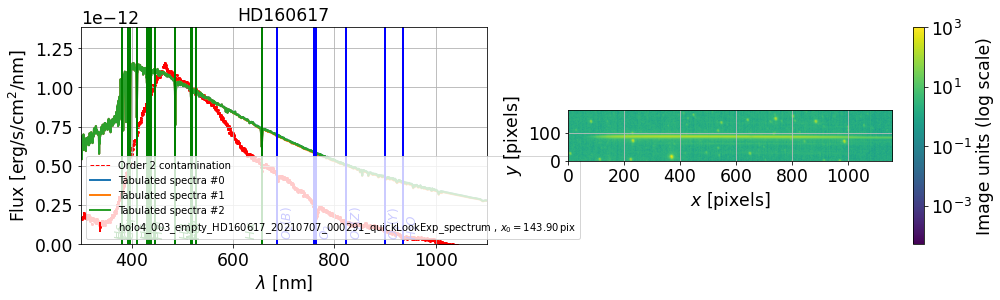

27 ) holo4_003_empty_HD160617_20210707_000296_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000296_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000296_quickLookExp_spectrum.fits


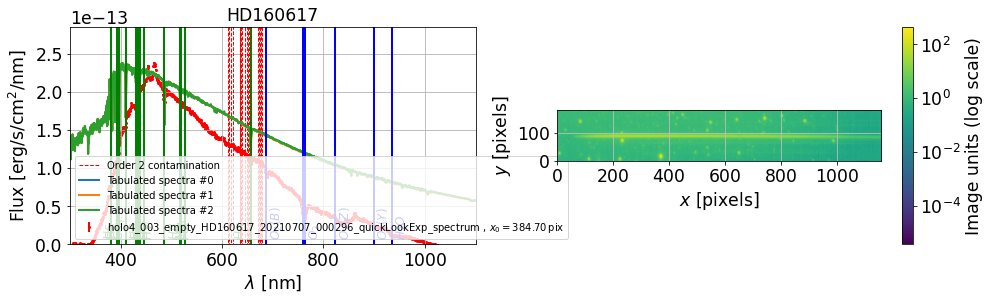

28 ) holo4_003_empty_HD160617_20210707_000297_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000297_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000297_quickLookExp_spectrum.fits


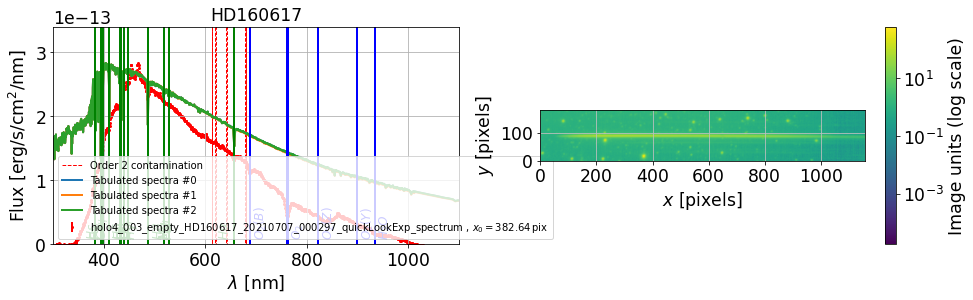

29 ) holo4_003_empty_HD160617_20210707_000298_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000298_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000298_quickLookExp_spectrum.fits


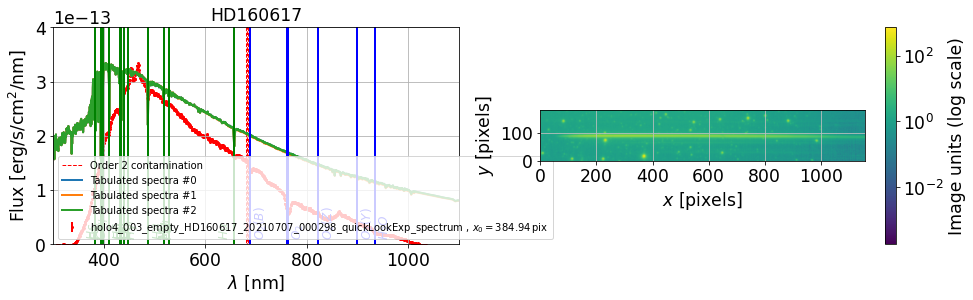

30 ) holo4_003_empty_HD160617_20210707_000303_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000303_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000303_quickLookExp_spectrum.fits


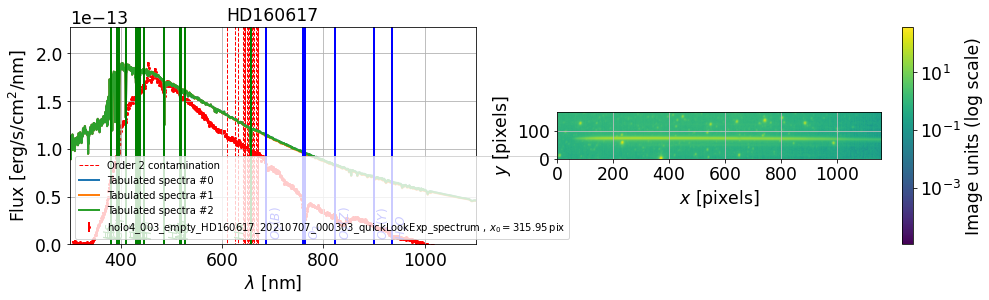

31 ) holo4_003_empty_HD160617_20210707_000304_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000304_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000304_quickLookExp_spectrum.fits


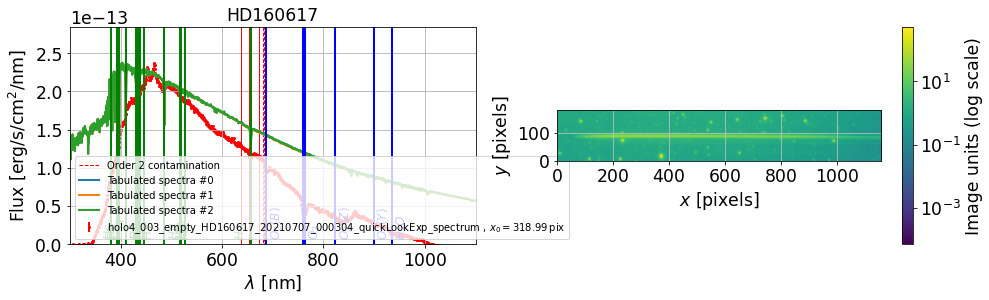

32 ) holo4_003_empty_HD160617_20210707_000305_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000305_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000305_quickLookExp_spectrum.fits


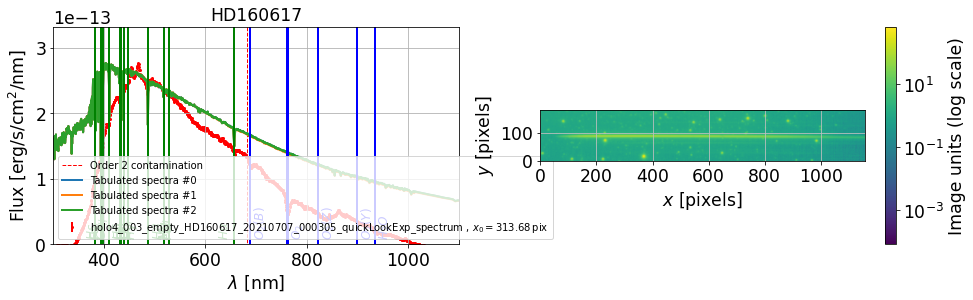

33 ) holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000318_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits


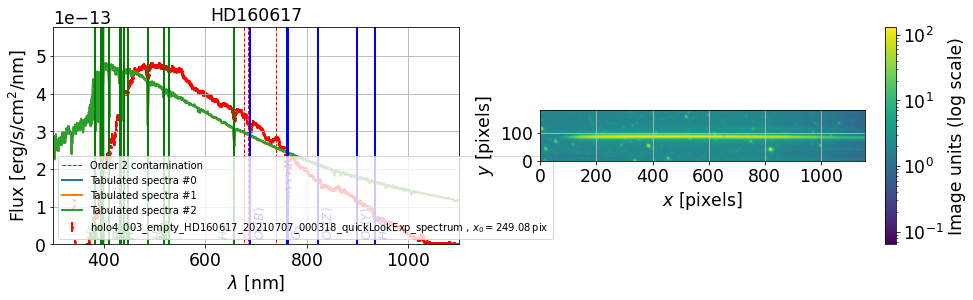

34 ) holo4_003_empty_HD160617_20210707_000319_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000319_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000319_quickLookExp_spectrum.fits


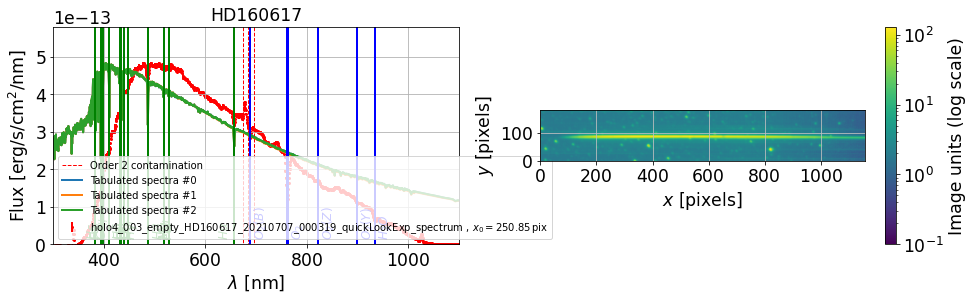

35 ) holo4_003_empty_HD160617_20210707_000320_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000320_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000320_quickLookExp_spectrum.fits


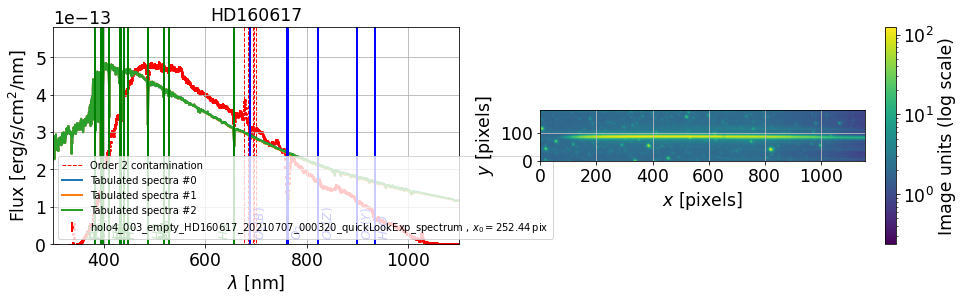

36 ) holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits


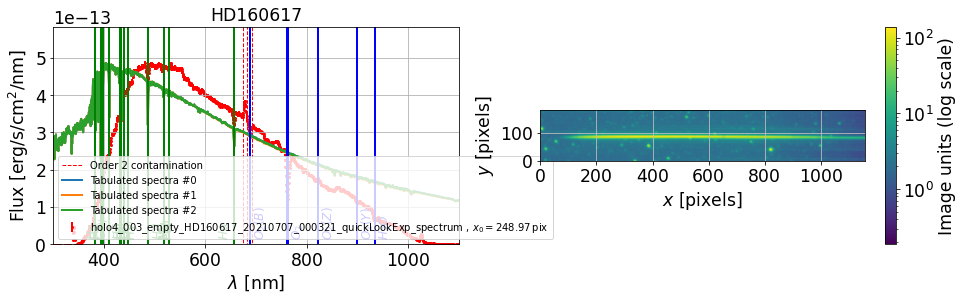

37 ) holo4_003_empty_HD160617_20210707_000322_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000322_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000322_quickLookExp_spectrum.fits


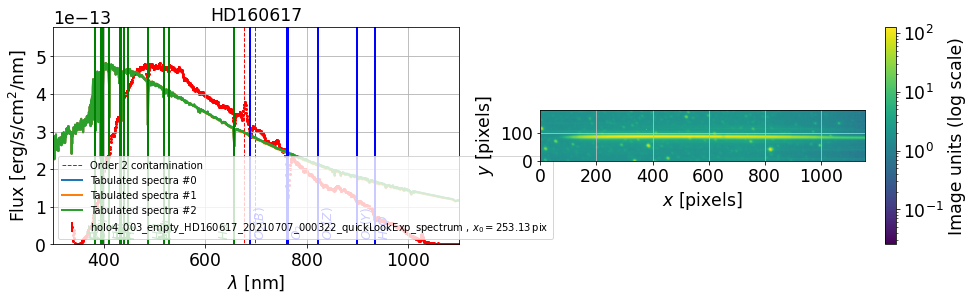

38 ) holo4_003_empty_HD160617_20210707_000323_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000323_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000323_quickLookExp_spectrum.fits


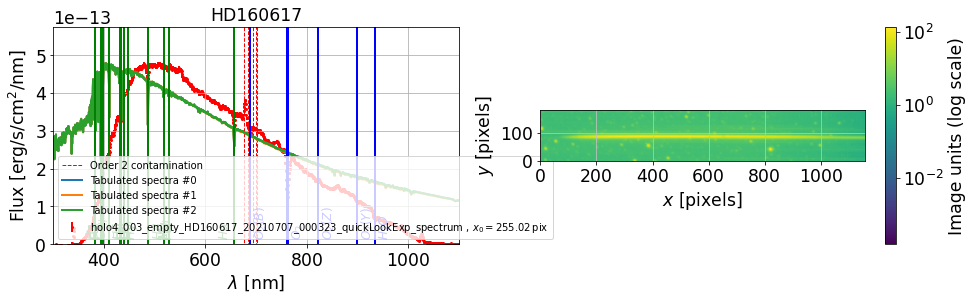

39 ) holo4_003_empty_HD160617_20210707_000324_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000324_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000324_quickLookExp_spectrum.fits


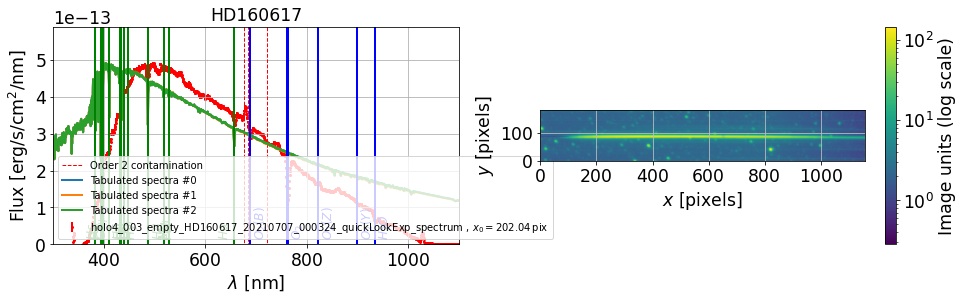

40 ) holo4_003_empty_HD160617_20210707_000325_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000325_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000325_quickLookExp_spectrum.fits


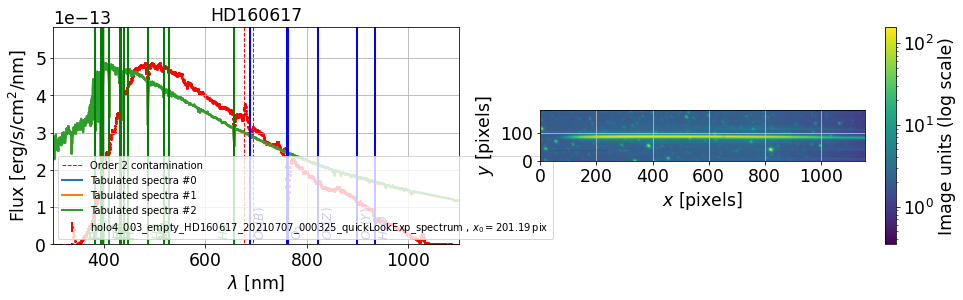

41 ) holo4_003_empty_HD160617_20210707_000326_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000326_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000326_quickLookExp_spectrum.fits


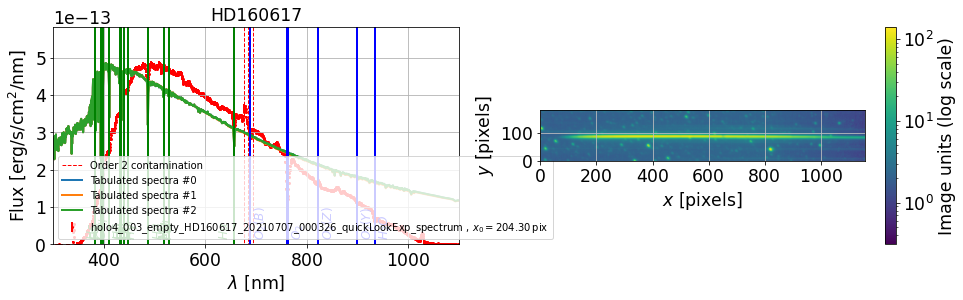

42 ) holo4_003_empty_HD160617_20210707_000328_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000328_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000328_quickLookExp_spectrum.fits


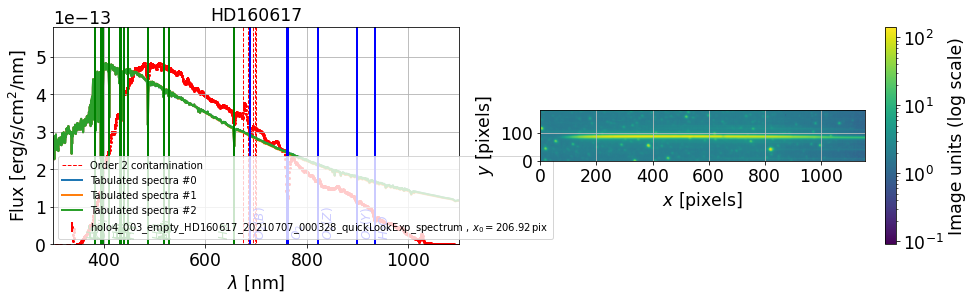

43 ) holo4_003_empty_HD160617_20210707_000329_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000329_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000329_quickLookExp_spectrum.fits


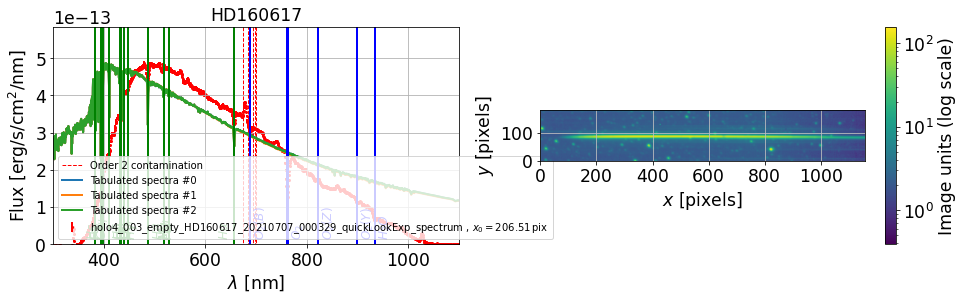

44 ) holo4_003_empty_HD160617_20210707_000330_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000330_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000330_quickLookExp_spectrum.fits


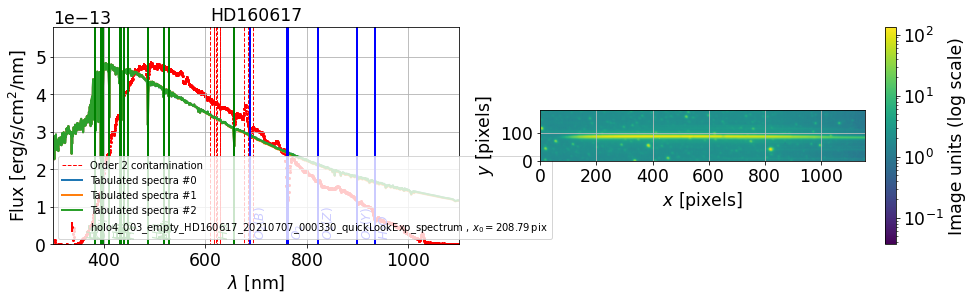

45 ) holo4_003_empty_HD160617_20210707_000331_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000331_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000331_quickLookExp_spectrum.fits


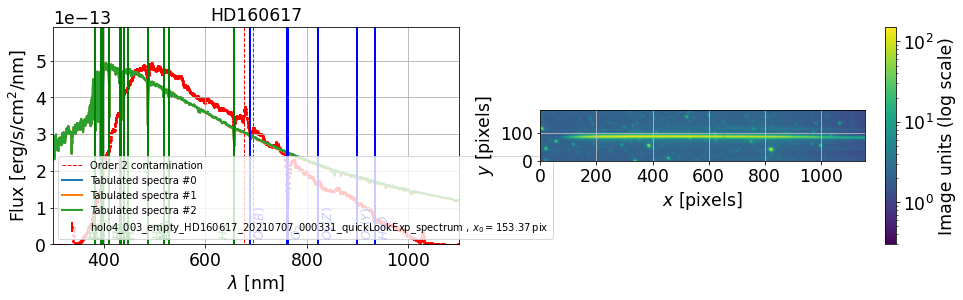

46 ) holo4_003_empty_HD160617_20210707_000332_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000332_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000332_quickLookExp_spectrum.fits


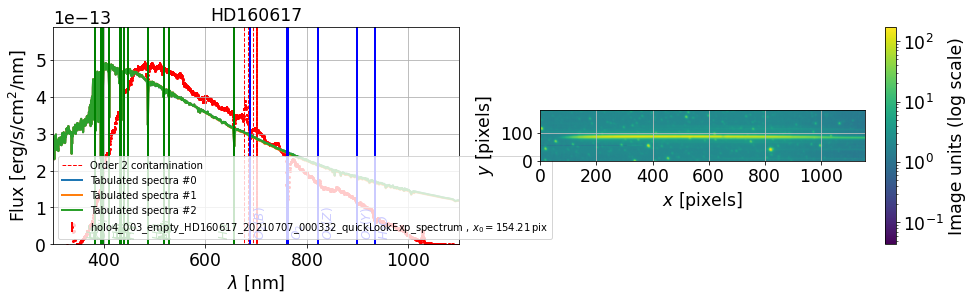

47 ) holo4_003_empty_HD160617_20210707_000334_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000334_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000334_quickLookExp_spectrum.fits


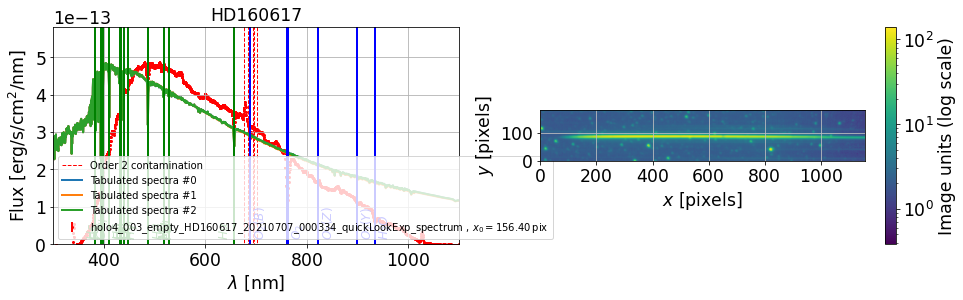

48 ) holo4_003_empty_HD160617_20210707_000335_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000335_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000335_quickLookExp_spectrum.fits


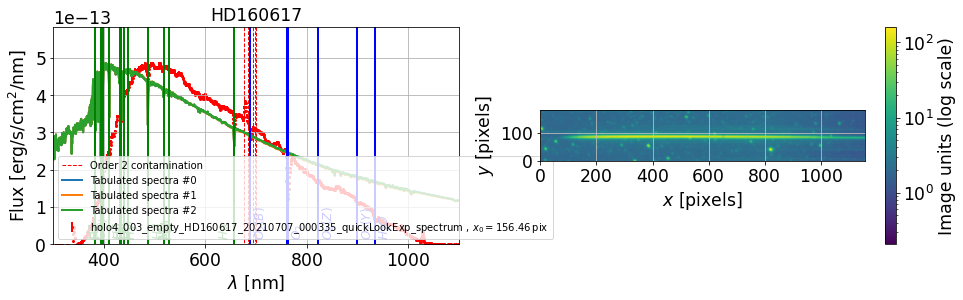

49 ) holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000336_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits


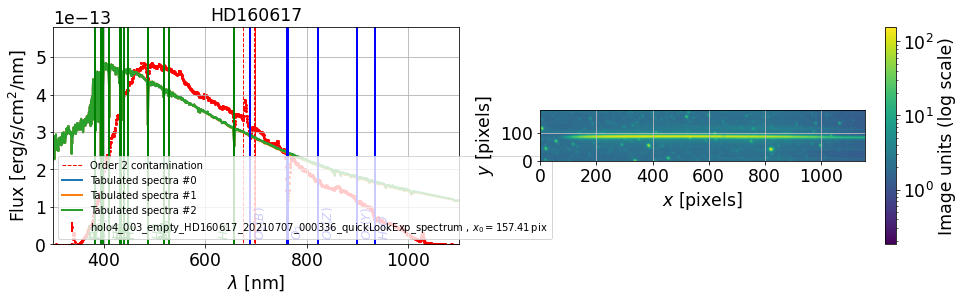

50 ) holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits


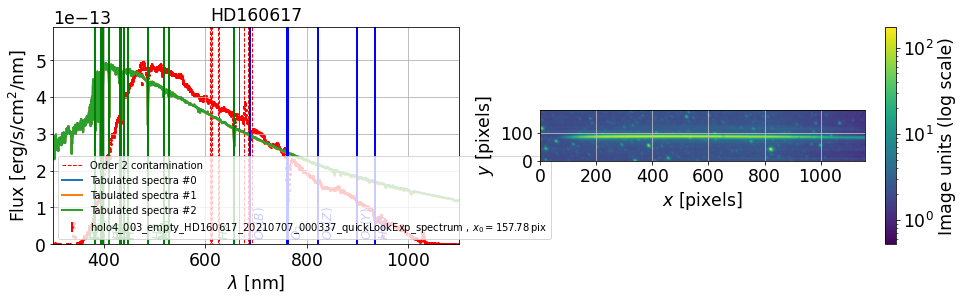

51 ) holo4_003_empty_HD160617_20210707_000338_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000338_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000338_quickLookExp_spectrum.fits


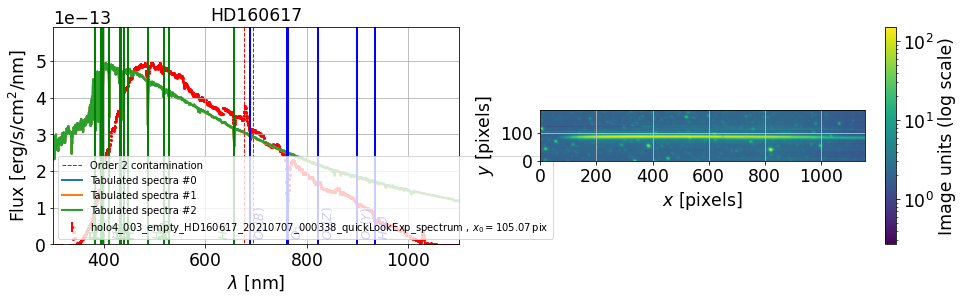

52 ) holo4_003_empty_HD160617_20210707_000339_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000339_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000339_quickLookExp_spectrum.fits


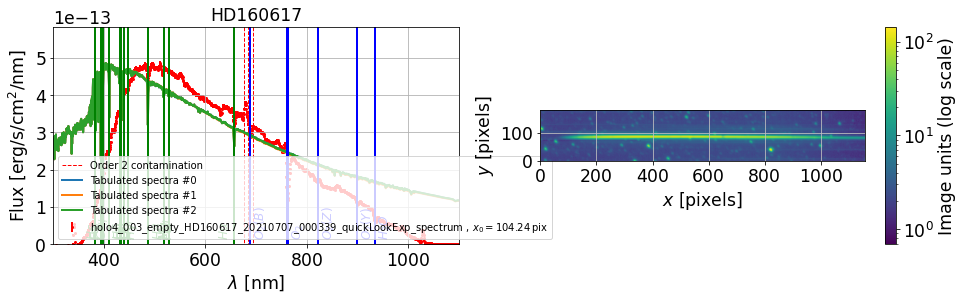

53 ) holo4_003_empty_HD160617_20210707_000340_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000340_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000340_quickLookExp_spectrum.fits


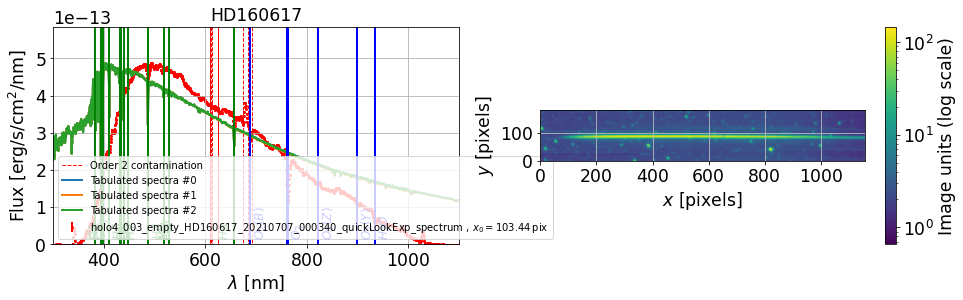

54 ) holo4_003_empty_HD160617_20210707_000341_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000341_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000341_quickLookExp_spectrum.fits


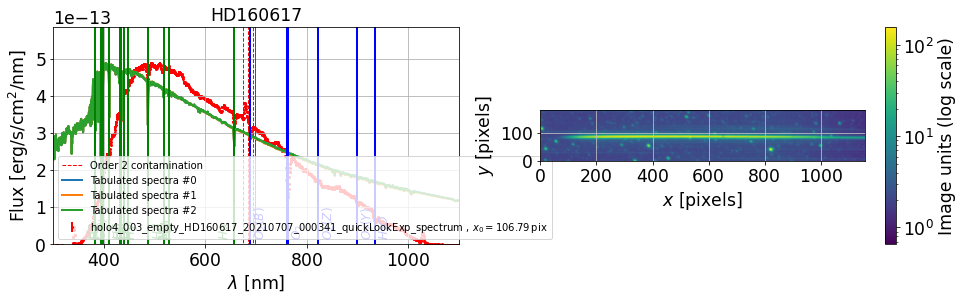

55 ) holo4_003_empty_HD160617_20210707_000342_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000342_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000342_quickLookExp_spectrum.fits


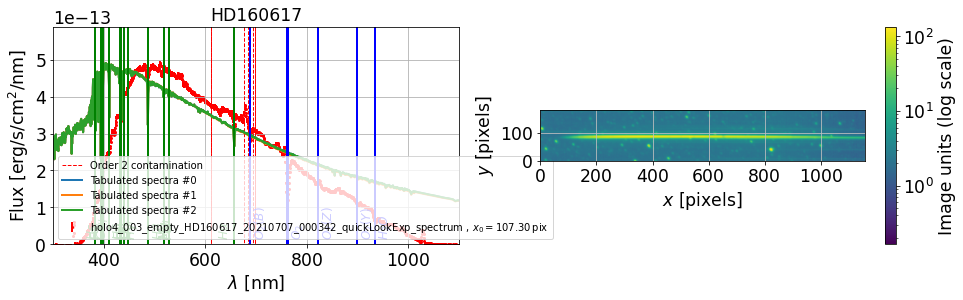

56 ) holo4_003_empty_HD160617_20210707_000343_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000343_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000343_quickLookExp_spectrum.fits


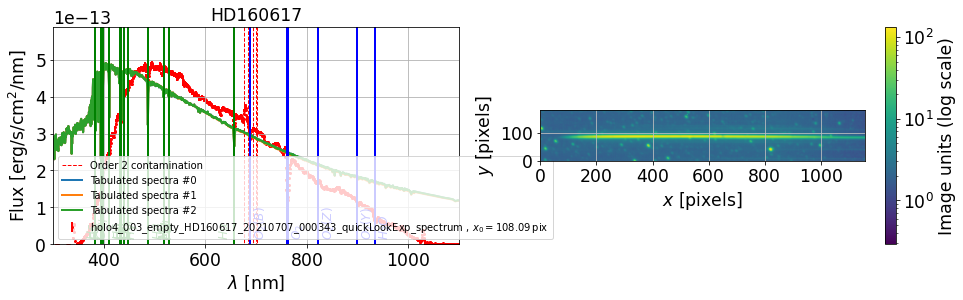

57 ) holo4_003_empty_HD160617_20210707_000344_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000344_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000344_quickLookExp_spectrum.fits


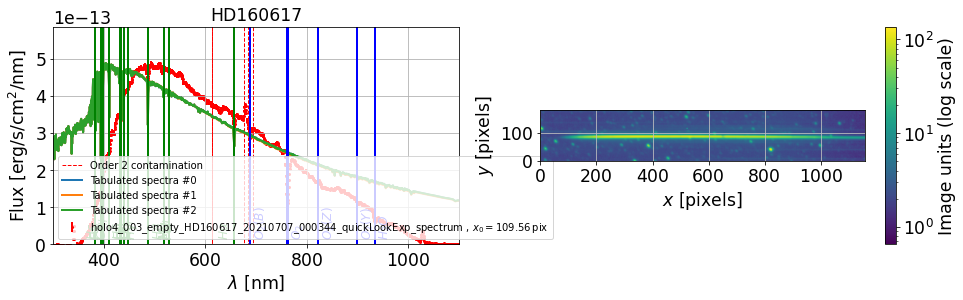

58 ) holo4_003_empty_HD160617_20210707_000345_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000345_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000345_quickLookExp_spectrum.fits


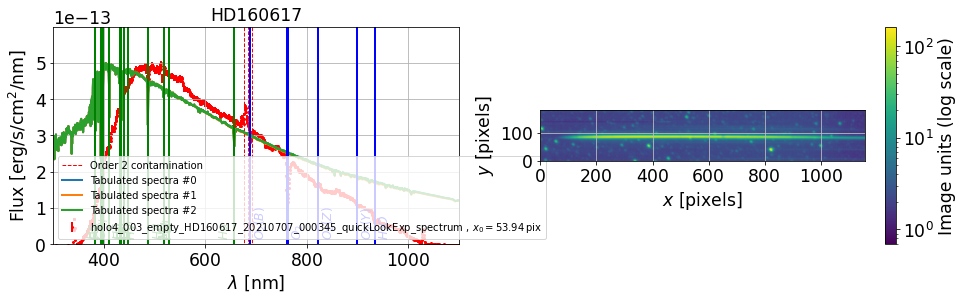

59 ) holo4_003_empty_HD160617_20210707_000346_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000346_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000346_quickLookExp_spectrum.fits


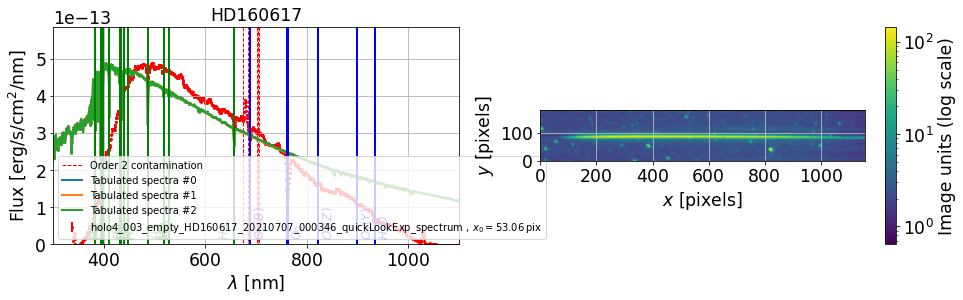

60 ) holo4_003_empty_HD160617_20210707_000347_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000347_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000347_quickLookExp_spectrum.fits


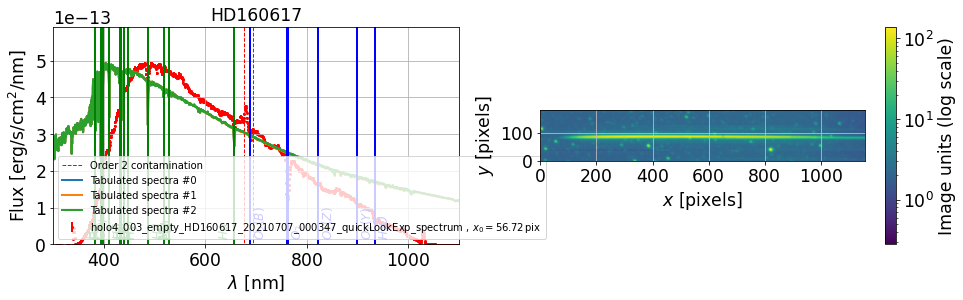

61 ) holo4_003_empty_HD160617_20210707_000348_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000348_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000348_quickLookExp_spectrum.fits


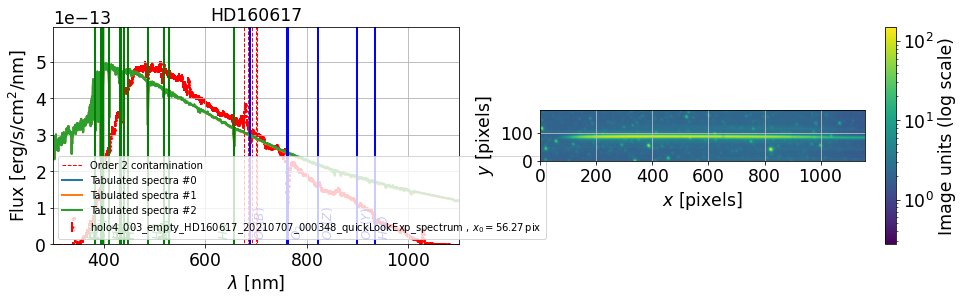

62 ) holo4_003_empty_HD160617_20210707_000349_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000349_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000349_quickLookExp_spectrum.fits


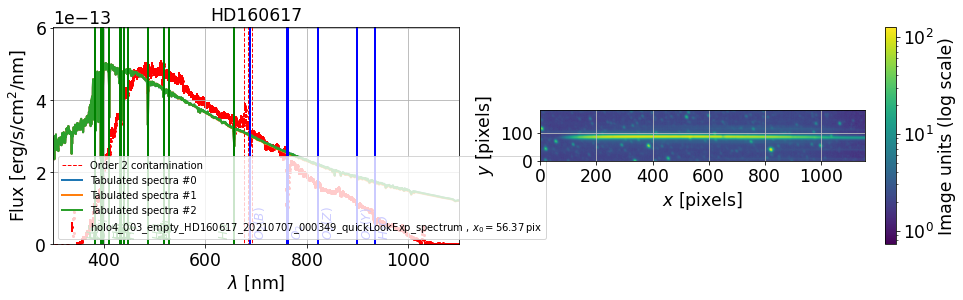

In [47]:
parameters.DISPLAY=False

infos = []
all_lambdas=[]
all_data=[]
all_num=[]

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    filename = os.path.basename(fullfilename)
    
    print(idx,")",filename," ",fullfilename)
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

# Bad reconstructed Spectra

In [48]:
#BAD_SPECTRA = [265,266,267,268,269,270,276,284,289]
#BAD_SPECTRA = [265,266,267,268,269,270,276,284,289,318]
BAD_SPECTRA= [265, 266, 267, 268, 272, 273, 276, 284, 289, 298, 321]  # from DCCD

# Extract information from files for later analysis of the scan

## Read the header of the spectra

In [49]:
from astropy.io import fits

idx=0
all_X=[]
all_Y=[]
all_angle=[]
all_tag=[]

for fullfilename in all_good_spectra_spectrum_files:
    
    # avoid simad timeout
    #s=Spectrum(fullfilename, config=config,fast_load=False)
    #header=s.header
    
    filename=os.path.basename(fullfilename)
    tagname=file_tag_forsorting(filename)
    tag=int(tagname)
    tagname=str(tag)
    
    
    #all_tag.append(tagname)
    all_tag.append(tag)
    hdul = fits.open(fullfilename)
    #hdul.info()
    header=hdul[0].header
    angle=header["ROTANGLE"]
    X=header["TARGETX"]*2.0
    Y=header["TARGETY"]*2.0
    all_X.append(X)
    all_Y.append(Y)
    all_angle.append(angle)
    
all_X=np.array(all_X)
all_Y=np.array(all_Y)
all_angle=np.array(all_angle)
all_tag=np.array(all_tag)

In [50]:
all_tag

array([248, 249, 250, 251, 252, 265, 266, 267, 268, 269, 270, 272, 273,
       274, 276, 278, 279, 280, 282, 284, 285, 286, 287, 288, 289, 290,
       291, 296, 297, 298, 303, 304, 305, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 328, 329, 330, 331, 332, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349])

## Access to information to fitted lines and Spectrogram

In [51]:
all_lines = []
all_spectrotables = []

for fullfilename in all_good_spectra_spectrum_files:
    
    # avoid simad timeout
    #s=Spectrum(fullfilename, config=config,fast_load=False)
    #header=s.header
    
    filename=os.path.basename(fullfilename)
    dirname= os.path.dirname(fullfilename)
    
    
    
    tagname=file_tag_forsorting(filename)
    tag=int(tagname)
    tagname=str(tag)
    
    
    print("-----",tagname,'--------',dirname)
    list_of_files=os.listdir(dirname)

    fullfilename_lines = fullfilename.replace("_spectrum.fits","_lines.csv")
    filename_lines = filename.replace("_spectrum.fits","_lines.csv")
    if filename_lines in list_of_files:
        print(f"\t found lines file {filename_lines}")
    else:
        print(f"\t >> ERROR : Not found lines file {filename_lines}")
        
    df_lines=pd.read_csv(fullfilename_lines)
    all_lines.append(df_lines)
    

    
    fullfilename_table = fullfilename.replace("_spectrum.fits","_table.csv")
    filename_table = filename.replace("_spectrum.fits","_table.csv")
    
    if filename_table in list_of_files:
        print(f"\t found spectrogram table {filename_table}")
    else:
        print(f"\t >> ERROR : Not found spectrogram table {filename_table}")
        
    df_table=pd.read_csv(fullfilename_table)
    all_spectrotables.append(df_table)
        
    

----- 248 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000248_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000248_quickLookExp_table.csv
----- 249 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000249_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000249_quickLookExp_table.csv
----- 250 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000250_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000250_quickLookExp_table.csv
----- 251 -------- /Users/da

----- 290 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000290_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000290_quickLookExp_table.csv
----- 291 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000291_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000291_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000291_quickLookExp_table.csv
----- 296 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000296_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000296_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000296_quickLookExp_table.csv
----- 297 -------- /Users/da

----- 337 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000337_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000337_quickLookExp_table.csv
----- 338 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000338_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000338_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000338_quickLookExp_table.csv
----- 339 -------- /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000339_quickLookExp/basespec
	 found lines file holo4_003_empty_HD160617_20210707_000339_quickLookExp_lines.csv
	 found spectrogram table holo4_003_empty_HD160617_20210707_000339_quickLookExp_table.csv
----- 340 -------- /Users/da

# Extract narrow scan

In [52]:
IdxNarrowScan=np.where(all_tag>=317)[0]

In [53]:
all_X_nr=all_X[IdxNarrowScan]
all_Y_nr=all_Y[IdxNarrowScan]
all_angle_nr=all_angle[IdxNarrowScan]
all_tag_nr=all_tag[IdxNarrowScan]

In [54]:
# should be sorted
all_tag_nr

array([318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331,
       332, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349])

# Position of images

In [56]:
def plotScanPosition(X,Y,tag,xlims=(0,4000),ylims=(0,4000),flag_annotate=True,figsize=(8,8),title=""):
    """
    """
    
    NN=len(X)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    
    plt.figure(figsize=figsize)
    
    sc = plt.scatter(X, Y, s=200, c=all_colors, cmap="seismic")
    #cb=plt.colorbar(sc)
    #cb.ax.set_ylabel('rotation angle (deg)')

    
    if flag_annotate:
        K=len(tag)
        for idx in range(K):
            plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15)
            #plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k",fontsize=10)
            #plt.text(X[idx],Y[idx],tag[idx],  horizontalalignment='center',verticalalignment='top',color="k",fontsize=10)
        
    
    plt.xlim(xlims)  
    plt.ylim(ylims)  
    
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    axes=plt.gca()
    axes.set_aspect('equal')
    
    plt.title(title)
    plt.tight_layout()
    
    plt.show()
            

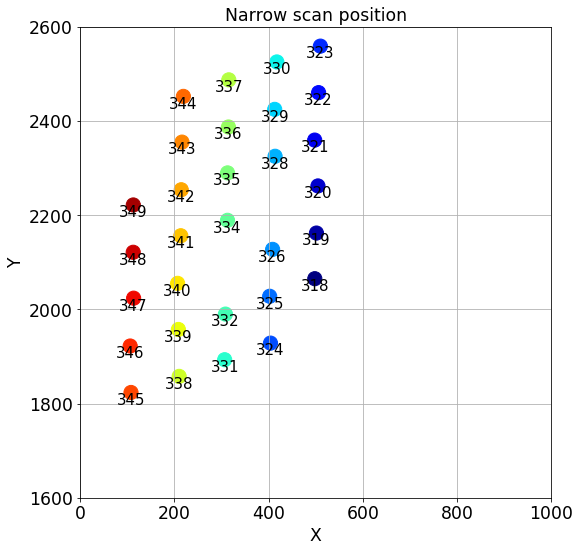

In [57]:
plotScanPosition(all_X_nr,all_Y_nr,all_tag_nr,xlims=(0,1000),ylims=(1600,2600),title="Narrow scan position")

# Analysis

## Rotation angle

In [58]:
def plotScanAngle(X,Y,ang,tag,xlims=(0,4000),ylims=(0,4000),flag_annotate=True,figsize=(12,12),title=""):
    """
    """
    plt.figure(figsize=figsize)
    
    sc = plt.scatter(X, Y, s=200, c=ang, cmap="seismic")
    cb=plt.colorbar(sc)
    cb.ax.set_ylabel('rotation angle (deg)')

    
    if flag_annotate:
        K=len(tag)
        for idx in range(K):
            plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15)
            #plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k",fontsize=10)
            #plt.text(X[idx],Y[idx],tag[idx],  horizontalalignment='center',verticalalignment='top',color="k",fontsize=10)
        
    
    plt.xlim(xlims)  
    plt.ylim(ylims)  
    
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    axes=plt.gca()
    axes.set_aspect('equal')
    
    plt.title(title)
    plt.tight_layout()
    
    plt.show()
            

### Extract narrow scan

In [59]:
#IdxNarrowScan=np.where(all_tag>=317)[0]

In [60]:
#all_X_nr=all_X[IdxNarrowScan]
#all_Y_nr=all_Y[IdxNarrowScan]
#all_angle_nr=all_angle[IdxNarrowScan]
#all_tag_nr=all_tag[IdxNarrowScan]

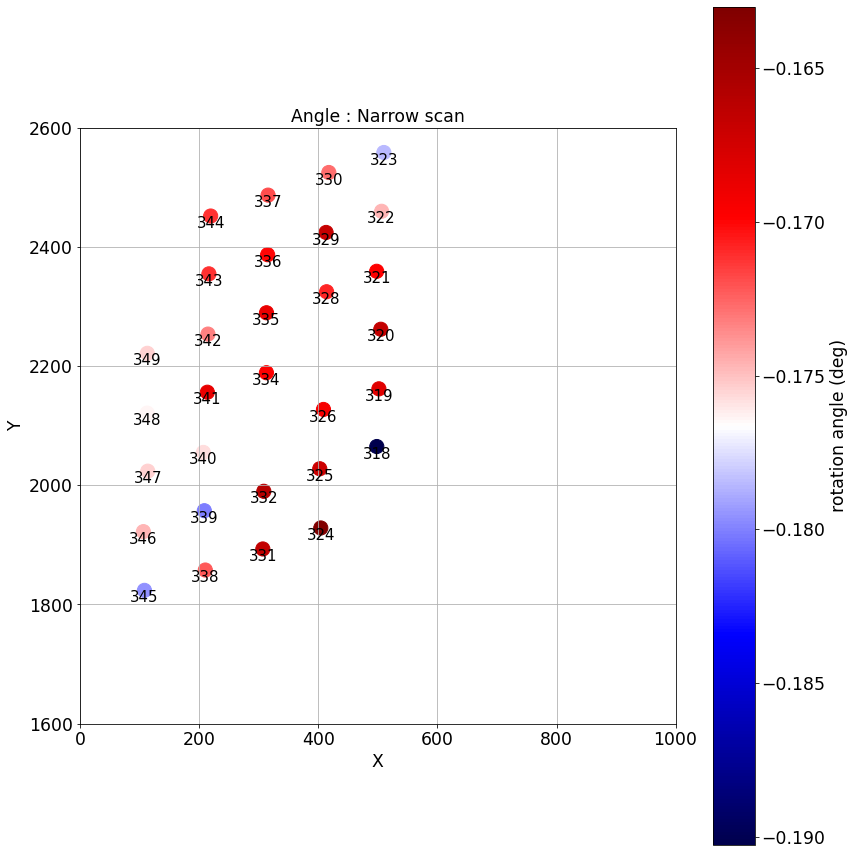

In [61]:
plotScanAngle(all_X_nr,all_Y_nr,all_angle_nr,all_tag_nr,xlims=(0,1000),ylims=(1600,2600),title="Angle : Narrow scan")

In [62]:
def plotScanAngleNoBad(X,Y,ang,tag,list_bad,xlims=(0,4000),ylims=(0,4000),flag_annotate=True,figsize=(12,12),title=""):
    """
    """
    plt.figure(figsize=figsize)
    
    # indexes of elements in tag that are in list_bad
    arg_badindexes=np.where(np.in1d(tag, list_bad))
    # indexes of elements in tag that are NOT in list_bad
    arg_goodindexes=np.where(np.in1d(all_tag,np.setdiff1d(all_tag, list_bad)))
    
    
    
    # plot goods
    sc = plt.scatter(X[arg_goodindexes], Y[arg_goodindexes], s=200, c=ang[arg_goodindexes], cmap="seismic")
    cb=plt.colorbar(sc)
    cb.ax.set_ylabel('rotation angle (deg)')
    
    # plot bad
    sc2 = plt.scatter(X[arg_badindexes], Y[arg_badindexes], s=200, c="k",alpha=1)

    
    if flag_annotate:
        K=len(tag)
        for idx in range(K):
            if tag[idx] in list_bad:
                plt.annotate(str(tag[idx]) + " (bad)",xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15)
            else:
                plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15, weight='bold')
            #plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k",fontsize=10)
            #plt.text(X[idx],Y[idx],tag[idx],  horizontalalignment='center',verticalalignment='top',color="k",fontsize=10)
        
    
    plt.xlim(xlims)  
    plt.ylim(ylims)  
    
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    axes=plt.gca()
    axes.set_aspect('equal')
    
    plt.title(title)
    plt.tight_layout()
    
    plt.show()
            

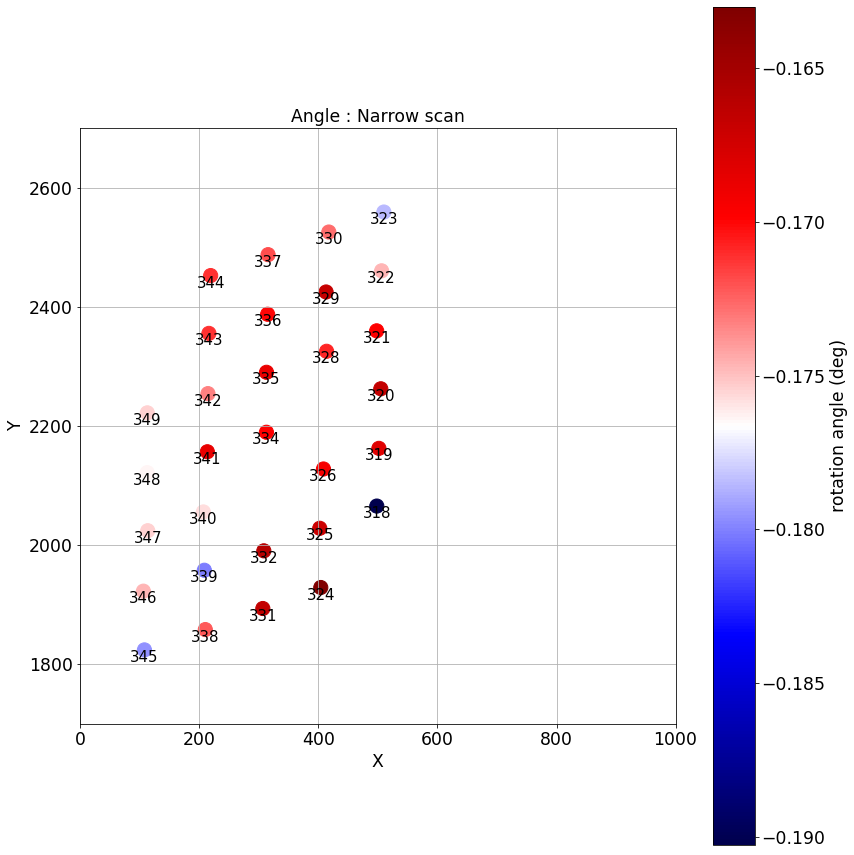

In [63]:
plotScanAngle(all_X_nr,all_Y_nr,all_angle_nr,all_tag_nr,xlims=(0,1000),ylims=(1700,2700),title="Angle : Narrow scan")

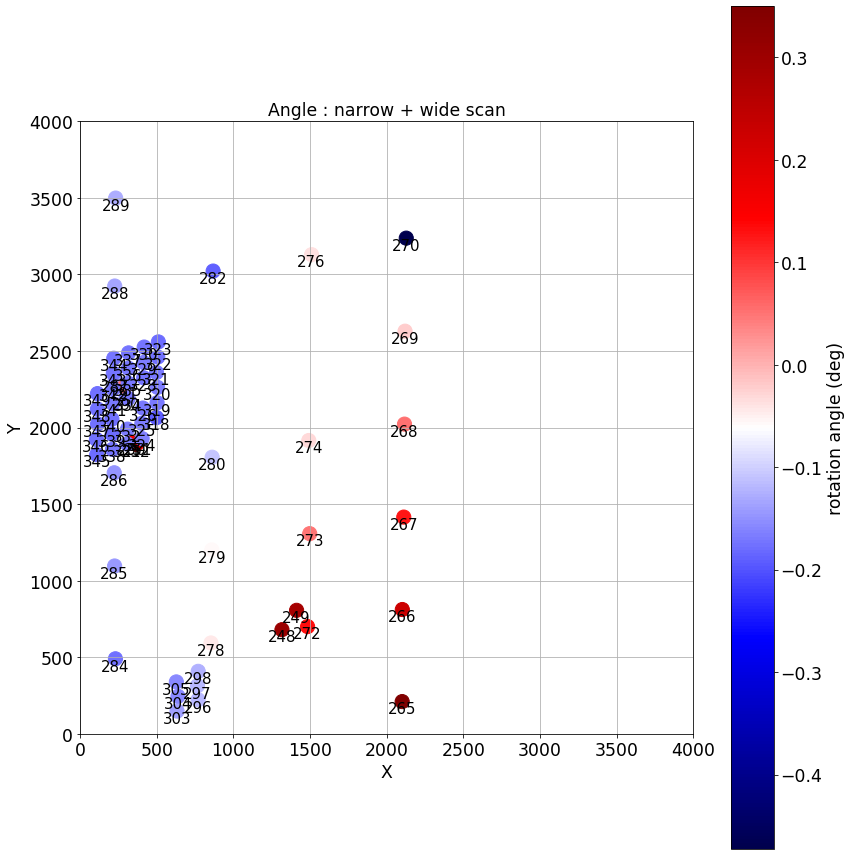

In [64]:
plotScanAngle(all_X,all_Y,all_angle,all_tag,xlims=(0,4000),ylims=(0,4000),title="Angle : narrow + wide scan")

In [65]:
type(all_tag[0])

numpy.int64

In [66]:
type(BAD_SPECTRA[0])

int

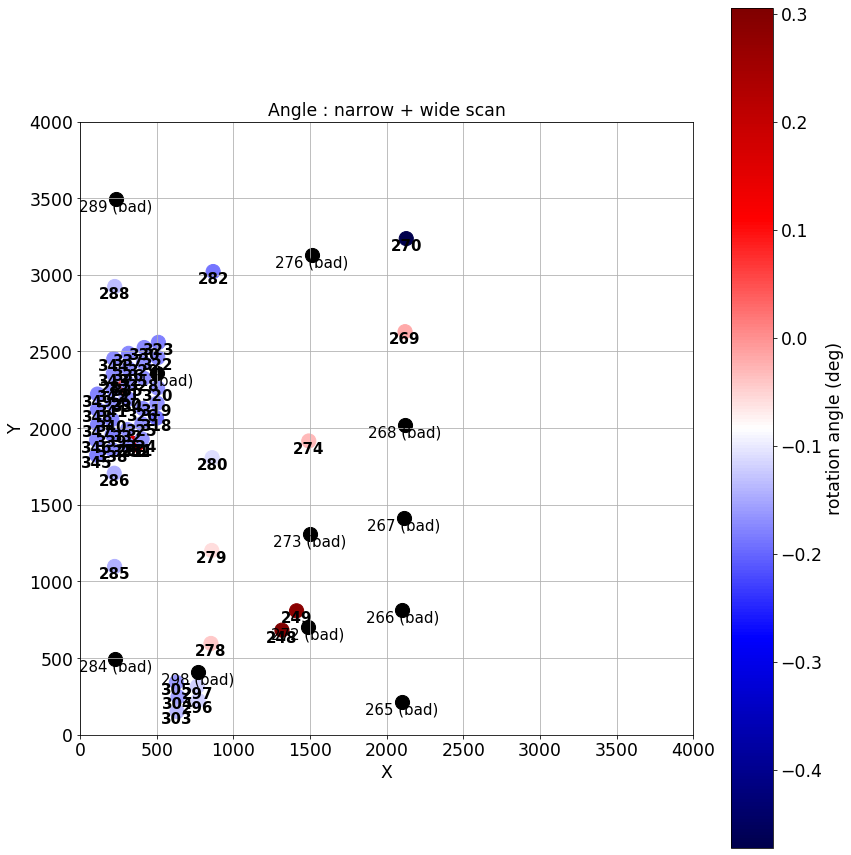

In [67]:
plotScanAngleNoBad(all_X,all_Y,all_angle,all_tag,BAD_SPECTRA,xlims=(0,4000),ylims=(0,4000),title="Angle : narrow + wide scan")

## Neff

In [68]:
DCCD   = 180.13 # mm
PIXELW = 0.01   # mm (10 microns)
REBIN  = 2      # rebining in Spectractor 

In [69]:
len(all_tag)

63

In [70]:
len(all_lines)

63

In [71]:
len(all_spectrotables)

63

### Get detected wavelength for lines  $H\alpha$ and $O_2$

In [72]:
def getwl(df,linename):
    """
    Get vavelength in dataframe pandas from the line name linename
    """
    
    N=len(df.loc[df["Line"] == linename])
    #print(f"\t {N} ")
    
    
    if N==0:
        wl=np.nan
    else:
        wl = df.loc[df["Line"] == linename]["Detected"].values[0]
    return wl
    

In [73]:
all_wl_halpha=[] # detected wavelength for that line
all_wl_o2=[]     # detected wavelength for that line

for idx,name in np.ndenumerate(all_tag):
    index=idx[0]
    
    wl_halpha=getwl(all_lines[index],"$H\\alpha$")
    wl_o2=getwl(all_lines[index],"$O_2$")
    all_wl_halpha.append(wl_halpha)
    all_wl_o2.append(wl_o2)    

### Get detected  lines  pixel position in spectrogram

In [74]:
def getlineposition(df,wl):
    
    if np.isnan(wl):
        return np.nan,np.nan,np.nan
    else:
        idx=np.argmin(np.abs(df.lambdas-wl))
        return (df.iloc[idx]["lambdas"]-wl),df.iloc[idx]["x_c"],df.iloc[idx]["y_c"]
        
    

In [75]:
all_xc_halpha=[] # pixel position for that line
all_yc_halpha=[] # pixel position for that line

all_xc_o2=[]
all_yc_o2=[]

for idx,name in np.ndenumerate(all_tag):
    index=idx[0]
    
    wl_halpha=all_wl_halpha[index]
    wl_o2=all_wl_o2[index]
    
    results_halpha=getlineposition(all_spectrotables[index],wl_halpha)
    
    all_xc_halpha.append(results_halpha[1])
    all_yc_halpha.append(results_halpha[2])
    
    results_o2=getlineposition(all_spectrotables[index],wl_o2)
    
    all_xc_o2.append(results_o2[1])
    all_yc_o2.append(results_o2[2])
    
    
    

### Compute Neff

In [76]:
all_Neff=[]

for idx,name in np.ndenumerate(all_tag):
    index=idx[0]
    
    neff=1/DCCD*(all_xc_halpha[index]-all_xc_o2[index])*REBIN*PIXELW/(all_wl_halpha[index]-all_wl_o2[index])*1e6
    
    all_Neff.append(neff)


In [77]:
all_Neff=np.array(all_Neff)

### Plot Neff

In [78]:
def plotScanNeff(X,Y,neff,tag,xlims=(0,4000),ylims=(0,4000),flag_annotate=True,figsize=(12,12),title=""):
    """
    """
    plt.figure(figsize=figsize)
    
    sc = plt.scatter(X, Y, s=200, c=neff, cmap="seismic")
    cb=plt.colorbar(sc)
    cb.ax.set_ylabel('$N_{eff}$(mm$^{-1}$)')

    
    if flag_annotate:
        K=len(tag)
        for idx in range(K):
            plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15)
            #plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k",fontsize=10)
            #plt.text(X[idx],Y[idx],tag[idx],  horizontalalignment='center',verticalalignment='top',color="k",fontsize=10)
        
    
    plt.xlim(xlims)  
    plt.ylim(ylims)  
    
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    axes=plt.gca()
    axes.set_aspect('equal')
    
    plt.title(title)
    plt.tight_layout()
    
    plt.show()
            

In [79]:
def plotScanNeffNoBad(X,Y,neff,tag,list_bad,xlims=(0,4000),ylims=(0,4000),flag_annotate=True,figsize=(12,12),title=""):
    """
    """
    plt.figure(figsize=figsize)
    
    # indexes of elements in tag that are in list_bad
    arg_badindexes=np.where(np.in1d(tag, list_bad))
    # indexes of elements in tag that are NOT in list_bad
    arg_goodindexes=np.where(np.in1d(all_tag,np.setdiff1d(all_tag, list_bad)))
    
    
    
    # plot goods
    sc = plt.scatter(X[arg_goodindexes], Y[arg_goodindexes], s=200, c=neff[arg_goodindexes], cmap="seismic")
    cb=plt.colorbar(sc)
    cb.ax.set_ylabel('$N_{eff}$(mm$^{-1}$)')
    
    # plot bad
    sc2 = plt.scatter(X[arg_badindexes], Y[arg_badindexes], s=200, c="k",alpha=1)

    
    if flag_annotate:
        K=len(tag)
        for idx in range(K):
            if tag[idx] in list_bad:
                plt.annotate(str(tag[idx]) + " (bad)",xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15)
            else:
                plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15, weight='bold')
            #plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k",fontsize=10)
            #plt.text(X[idx],Y[idx],tag[idx],  horizontalalignment='center',verticalalignment='top',color="k",fontsize=10)
        
    
    plt.xlim(xlims)  
    plt.ylim(ylims)  
    
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    axes=plt.gca()
    axes.set_aspect('equal')
    
    plt.title(title)
    plt.tight_layout()
    
    plt.show()
            

In [80]:
all_Neff_nr = all_Neff[IdxNarrowScan]

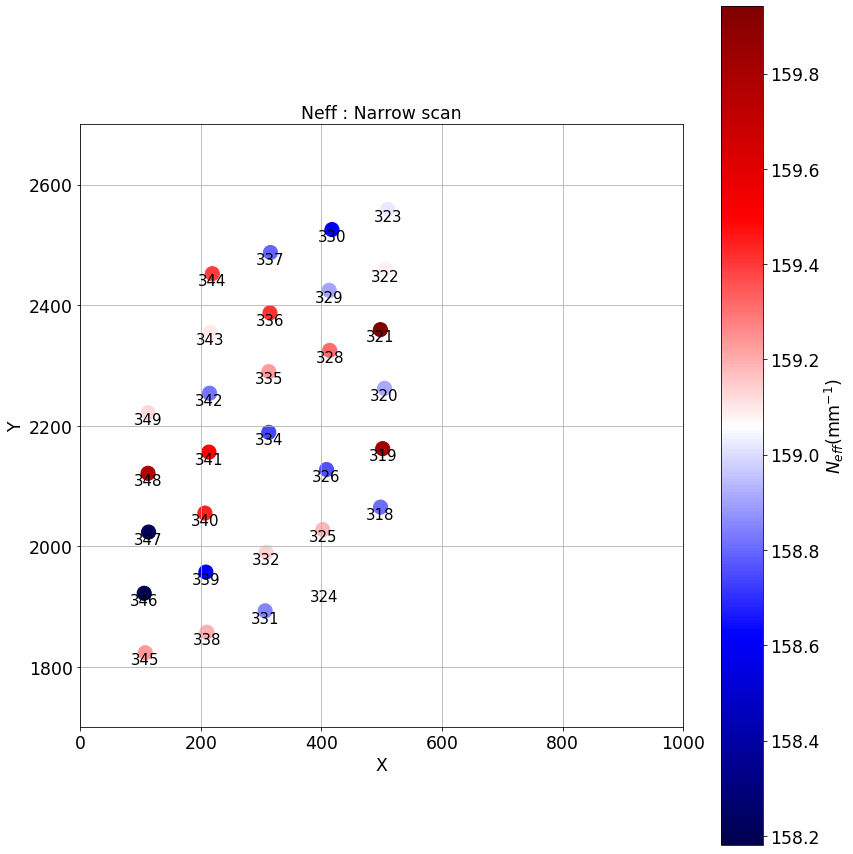

In [81]:
plotScanNeff(all_X_nr,all_Y_nr,all_Neff_nr,all_tag_nr,xlims=(0,1000),ylims=(1700,2700),title="Neff : Narrow scan")

In [82]:
BAD_SPECTRA

[265, 266, 267, 268, 272, 273, 276, 284, 289, 298, 321]

In [83]:
BAD_NEFF=all_tag[np.where(np.isnan(all_Neff))[0]]

BAD_NEFF

array([265, 266, 267, 268, 269, 270, 276, 289, 298])

In [84]:
list_bad_neff=np.union1d(BAD_SPECTRA,BAD_NEFF)
list_bad_neff

array([265, 266, 267, 268, 269, 270, 272, 273, 276, 284, 289, 298, 321])

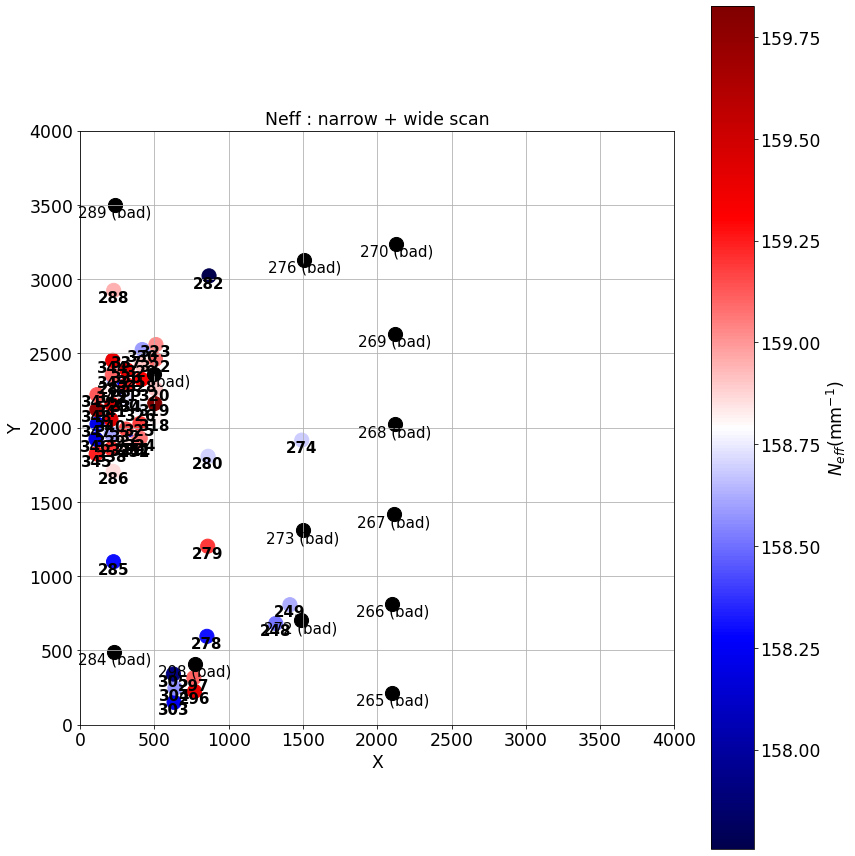

In [85]:
plotScanNeffNoBad(all_X,all_Y,all_Neff,all_tag,list_bad_neff,xlims=(0,4000),ylims=(0,4000),title="Neff : narrow + wide scan")

# Save files

In [86]:
all_tag

array([248, 249, 250, 251, 252, 265, 266, 267, 268, 269, 270, 272, 273,
       274, 276, 278, 279, 280, 282, 284, 285, 286, 287, 288, 289, 290,
       291, 296, 297, 298, 303, 304, 305, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 328, 329, 330, 331, 332, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349])

In [87]:
BAD_SPECTRA

[265, 266, 267, 268, 272, 273, 276, 284, 289, 298, 321]

In [88]:
arg_badindexes=np.where(np.in1d(all_tag, BAD_SPECTRA))
# indexes of elements in tag that are NOT in list_bad
arg_goodindexes=np.where(np.in1d(all_tag,np.setdiff1d(all_tag, BAD_SPECTRA)))

In [89]:
arg_badindexes

(array([ 5,  6,  7,  8, 11, 12, 14, 19, 24, 29, 36]),)

In [90]:
arg_goodindexes

(array([ 0,  1,  2,  3,  4,  9, 10, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25,
        26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62]),)

In [91]:
FLAG_GOOD = np.where(np.in1d(all_tag, BAD_SPECTRA),False,True)
FLAG_GOOD

array([ True,  True,  True,  True,  True, False, False, False, False,
        True,  True, False, False,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [92]:
FLAG_GOOD[np.where(np.isnan(all_Neff))[0]] = False
FLAG_GOOD

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## Narrow scan

In [179]:
file_csv="narrowscan_2021-07-07.csv"
file_xlsx="narrowscan_2021-07-07.xlsx"

In [180]:
XWIDTHpix = 4000
YWIDTHpix = 4070

In [181]:
XWIDTHmm = 4000*PIXELW
YWIDTHmm = 4070*PIXELW

### must convert position relative to CCD center

In [182]:
df= pd.DataFrame()

In [183]:
df["X(mm)"]=all_X_nr*PIXELW - XWIDTHmm/2.
df["Y(mm)"]= (YWIDTHpix - all_Y_nr)*PIXELW - YWIDTHmm/2 
df["degré"]=all_angle_nr
df["tag"]=all_tag_nr
df["Xpix"]=all_X_nr - XWIDTHpix/2.
df["Ypix"]= (YWIDTHpix - all_Y_nr) - YWIDTHpix/2.
df["Neff"]=all_Neff[IdxNarrowScan]
df["FlagGood"] = FLAG_GOOD[IdxNarrowScan]

In [184]:
df

X(mm)     Y(mm)     degré  tag         Xpix        Ypix        Neff  \
0  -15.018391 -0.302659 -0.190253  318 -1501.839080  -30.265929  158.808411   
1  -14.982936 -1.271912 -0.168207  319 -1498.293580 -127.191212  159.825309   
2  -14.951200 -2.272468 -0.166700  320 -1495.119952 -227.246845  158.911415   
3  -15.020588 -3.245897 -0.169779  321 -1502.058766 -324.589715  159.940737   
4  -14.937495 -4.253821 -0.174680  322 -1493.749510 -425.382051  159.087628   
5  -14.899517 -5.241174 -0.178528  323 -1489.951749 -524.117394  159.025091   
6  -15.959115  1.065228 -0.163014  324 -1595.911484  106.522817  159.067331   
7  -15.976251  0.070602 -0.167150  325 -1597.625139    7.060212  159.182435   
8  -15.914033 -0.925405 -0.169371  326 -1591.403338  -92.540517  158.761487   
9  -15.861598 -2.902365 -0.170870  328 -1586.159815 -290.236549  159.312912   
10 -15.869848 -3.898473 -0.166778  329 -1586.984772 -389.847323  158.906878   
11 -15.824127 -4.905326 -0.172738  330 -1582.412662 -490.532643  158.595825   
12 -16.932534  1.417821 -0.166622  331 -1693.253361  141.782073  158.852915   
13 -16.915767  0.449185 -0.165954  332 -1691.576692   44.918509  159.141569   
14 -16.872016 -1.542423 -0.169811  334 -1687.201594 -154.242324  158.739213   
15 -16.870783 -2.549532 -0.168755  335 -1687.078334 -254.953221  159.231612   
16 -16.851869 -3.524265 -0.170017  336 -1685.186917 -352.426533  159.406345   
17 -16.844366 -4.525361 -0.171903  337 -1684.436624 -452.536145  158.798354   
18 -17.898606  1.771628 -0.172246  338 -1789.860623  177.162792  159.197094   
19 -17.915105  0.775284 -0.180057  339 -1791.510482   77.528368  158.606923   
20 -17.931287 -0.203872 -0.175695  340 -1793.128670  -20.387212  159.442964   
21 -17.864125 -1.214755 -0.168559  341 -1786.412521 -121.475537  159.498243   
22 -17.854081 -2.191396 -0.173230  342 -1785.408105 -219.139580  158.820282   
23 -17.838116 -3.203017 -0.171195  343 -1783.811617 -320.301665  159.101178   
24 -17.808833 -4.174204 -0.171178  344 -1780.883272 -417.420430  159.392926   
25 -18.921111  2.113223 -0.179557  345 -1892.111148  211.322273  159.235894   
26 -18.938706  1.126771 -0.174666  346 -1893.870581  112.677052  158.180204   
27 -18.865694  0.111250 -0.175392  347 -1886.569429   11.125003  158.216227   
28 -18.874612 -0.863775 -0.176366  348 -1887.461164  -86.377457  159.758228   
29 -18.872661 -1.868449 -0.175399  349 -1887.266135 -186.844855  159.122917   

    FlagGood  
0       True  
1       True  
2       True  
3      False  
4       True  
5       True  
6       True  
7       True  
8       True  
9       True  
10      True  
11      True  
12      True  
13      True  
14      True  
15      True  
16      True  
17      True  
18      True  
19      True  
20      True  
21      True  
22      True  
23      True  
24      True  
25      True  
26      True  
27      True  
28      True  
29      True

In [185]:
df.to_excel(file_xlsx)
df.to_csv(file_csv)

### Wide and narrow scan

In [186]:
file_csv="narrowwidescan_2021-07-07.csv"
file_xlsx="narrowwidescan_2021-07-07.xlsx"

In [187]:
df= pd.DataFrame()

In [188]:
N=len(all_X)

In [189]:
df["X(mm)"]=all_X*PIXELW - XWIDTHmm/2.
df["Y(mm)"]= (YWIDTHpix  - all_Y)*PIXELW - YWIDTHmm/2. 
df["degré"]=all_angle
df["tag"]=all_tag
df["Xpix"]=all_X - XWIDTHpix/2.
df["Xpix"]=  (YWIDTHpix - all_Y) - YWIDTHpix/2.
df["Neff"]=all_Neff
df["FlagGood"] = FLAG_GOOD
df["NarrowScan"] = np.repeat(False,N)
df["NarrowScan"].iloc[IdxNarrowScan] = True

/users/dagoret/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [190]:
df

X(mm)      Y(mm)     degré  tag         Xpix        Neff  FlagGood  \
0   -6.834332  13.536706  0.304839  248  1353.670602  158.510091      True   
1   -5.879631  12.273796  0.287949  249  1227.379635  158.627289      True   
2  -16.641820   1.325806  0.162526  250   132.580559  158.089677      True   
3  -16.236803   1.326900  0.193625  251   132.690005  158.524176      True   
4  -16.358922   1.439759  0.175763  252   143.975923  159.022092      True   
5    1.010009  18.228816  0.349720  265  1822.881609         NaN     False   
6    1.019691  12.220971  0.226629  266  1222.097148         NaN     False   
7    1.114230   6.190286  0.126693  267   619.028589         NaN     False   
8    1.162761   0.122769  0.052396  268    12.276853         NaN     False   
9    1.198235  -5.940731 -0.019687  269  -594.073070         NaN     False   
10   1.276260 -12.012332 -0.472441  270 -1201.233229         NaN     False   
11  -5.161436  13.334371  0.131782  272  1333.437055  158.066574     False   
12  -5.022700   7.269628  0.049467  273   726.962841  158.856869     False   
13  -5.082953   1.192528 -0.031874  274   119.252844  158.688620      True   
14  -4.900590 -10.935294 -0.035984  276 -1093.529425         NaN     False   
15 -11.467857  14.405115 -0.044131  278  1440.511503  158.307275      True   
16 -11.414769   8.336375 -0.057962  279   833.637473  159.190137      True   
17 -11.390140   2.282971 -0.109202  280   228.297126  158.696848      True   
18 -11.325032  -9.865094 -0.189580  282  -986.509402  157.756110      True   
19 -17.701432  15.436813 -0.175091  284  1543.681261  164.638979     False   
20 -17.754264   9.380842 -0.143830  285   938.084157  158.304574      True   
21 -17.778665   3.298009 -0.147311  286   329.800944  158.861713      True   
22 -17.720479  -2.792227 -0.143966  287  -279.222725  158.640232      True   
23 -17.746776  -8.888499 -0.134660  288  -888.849883  158.951037      True   
24 -17.685872 -14.628447 -0.125815  289 -1462.844703         NaN     False   
25 -17.002933  -1.649185 -0.158930  290  -164.918546  158.870157      True   
26 -17.122036  -2.324399  0.047934  291  -232.439942  158.277148      True   
27 -12.306051  18.109928 -0.117473  296  1810.992812  159.400742      True   
28 -12.347209  17.196280 -0.118144  297  1719.628022  159.108551      True   
29 -12.301107  16.254969 -0.124088  298  1625.496904         NaN     False   
30 -13.680905  18.848643 -0.136701  303  1884.864281  158.225356      True   
31 -13.620198  17.884238 -0.155837  304  1788.423821  158.569144      True   
32 -13.726430  16.944743 -0.156704  305  1694.474334  157.903340      True   
33 -15.018391  -0.302659 -0.190253  318   -30.265929  158.808411      True   
34 -14.982936  -1.271912 -0.168207  319  -127.191212  159.825309      True   
35 -14.951200  -2.272468 -0.166700  320  -227.246845  158.911415      True   
36 -15.020588  -3.245897 -0.169779  321  -324.589715  159.940737     False   
37 -14.937495  -4.253821 -0.174680  322  -425.382051  159.087628      True   
38 -14.899517  -5.241174 -0.178528  323  -524.117394  159.025091      True   
39 -15.959115   1.065228 -0.163014  324   106.522817  159.067331      True   
40 -15.976251   0.070602 -0.167150  325     7.060212  159.182435      True   
41 -15.914033  -0.925405 -0.169371  326   -92.540517  158.761487      True   
42 -15.861598  -2.902365 -0.170870  328  -290.236549  159.312912      True   
43 -15.869848  -3.898473 -0.166778  329  -389.847323  158.906878      True   
44 -15.824127  -4.905326 -0.172738  330  -490.532643  158.595825      True   
45 -16.932534   1.417821 -0.166622  331   141.782073  158.852915      True   
46 -16.915767   0.449185 -0.165954  332    44.918509  159.141569      True   
47 -16.872016  -1.542423 -0.169811  334  -154.242324  158.739213      True   
48 -16.870783  -2.549532 -0.168755  335  -254.953221  159.231612      True   
49 -16.851869  -3.524265 -0.170017  336  -352.426533  159.406345      True   
50 -16.844366  -4.525361 -0.17

In [191]:
df.to_excel(file_xlsx)
df.to_csv(file_csv)